### Import the libraries and modules we will use

In [ ]:
!pip install gpytorch
import numpy as np
import pandas as pd
import time
import math
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score
from gpytorch.models import ExactGP
from gpytorch.kernels import MaternKernel
from gpytorch.distributions import MultivariateNormal
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.kernels import RBFKernel
from gpytorch.distributions import MultivariateNormal
from xgboost import XGBRegressor
from torch.utils.data import TensorDataset, DataLoader
from gpytorch.mlls.variational_elbo import VariationalELBO
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.kernels import ScaleKernel, MaternKernel
from gpytorch.variational import CholeskyVariationalDistribution, VariationalStrategy
from gpytorch.models import ApproximateGP
from gpytorch.means import ConstantMean
from gpytorch.means import ZeroMean
from gpytorch.distributions import MultivariateNormal
from google.colab import drive

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.7/277.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.3/176.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

## INITIAL EXAMPLE CODE

SVGP CODE

In [ ]:
class SparseGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution = CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy = VariationalStrategy(self,inducing_points,variational_distribution,learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module=ConstantMean()
        self.covar_module=ScaleKernel(MaternKernel(nu=2.5, ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

FULL GP CODE

In [ ]:
class GPTmodel_2(ExactGP):
  def __init__(self,train_x,train_y,likelihood,nu):
    super(GPTmodel_2,self).__init__(train_x,train_y,likelihood)
    self.mean_module=gpytorch.means.ConstantMean()
    self.covar_module=gpytorch.kernels.ScaleKernel(MaternKernel(nu=nu))

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

TRAINING FUNCTIONS

FULL GP TRAINING FUNCTION

In [ ]:
def train_model(model,likelihood,num_epochs,lr,x_train,y_train):
  #Primero selecciono todos los parámetros no duplicados del modelo
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params + likelihood_params))
  optimizer=torch.optim.Adam(all_params,lr=lr)
  mll=gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)

  #Defino ahora variables dónde guardar las épocas y el loss
  epocas=[]
  perdida=[]

  #Inicializo la función de entrenamiento
  model.train()
  likelihood.train()

  #Entrenando el modelo
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    loss=-mll(output,y_train)
    loss.backward()  # Retropropagamos los gradientes
    optimizer.step()  # Actualizamos los parámetros del modelo
    #Guardamos las variables de pérdida y época
    perdida.append(loss.item())
    epocas.append(i+1)

  return epocas,perdida,model

SVGP TRAINING FUNCTION

In [ ]:
def train_model_Sparse(model,likelihood,num_epochs,lr,x_train,y_train):
  #Primero selecciono todos los parámetros no duplicados del modelo
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params + likelihood_params))
  optimizer=torch.optim.Adam(all_params, lr=lr)
  #optimizer=torch.optim.Adam(model.parameters(),lr=lr)
  mll=gpytorch.mlls.VariationalELBO(likelihood,model,num_data=y_train.size(0))

  #Defino ahora variables dónde guardar las épocas y el loss
  epocas=[]
  perdida=[]

  #Inicializo la función de entrenamiento
  model.train()
  likelihood.train()

  #Entrenando el modelo
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    #Calculamos la pérdida usando la función forward en lugar de marginal
    loss=-mll(output,y_train)
    loss.backward()  # Retropropagamos los gradientes
    optimizer.step()  # Actualizamos los parámetros del modelo
    #Guardamos las variables de pérdida y época
    perdida.append(loss.item())
    epocas.append(i+1)

  return epocas,perdida,model

DEFINE MODEL EVALUATION FUNCTION

In [ ]:
def evaluate_model(model,likelihood,x_test):
  model.eval()
  likelihood.eval()
  with torch.no_grad():
    test_preds=likelihood(model(x_test))
    preds=test_preds.mean
  return preds

DEFINE TRAINING DATA

In [ ]:
#Datos de entrenamiento
train_x=torch.linspace(0,50,1000).unsqueeze(-1)
train_y=torch.sin(train_x*(2*math.pi)/10)
train_y=train_y.squeeze()

#Datos de testeo
test_x=torch.linspace(0,10,50).unsqueeze(-1)
test_y=torch.sin(test_x*(2 *math.pi)/10)
test_y=test_y.squeeze()

#Transformo a tensores
train_y=torch.tensor(train_y,dtype=torch.float32)
test_y=torch.tensor(test_y,dtype=torch.float32)
x_train=torch.tensor(train_x,dtype=torch.float32)
x_test=torch.tensor(test_x,dtype=torch.float32)


#Me genero también el conjunto de datos representativos que los voy a necesitar
indices_aleatorios=torch.randperm(len(train_x))[:5]
inducing_points=train_x[indices_aleatorios]
indices_aleatorios_2=torch.randperm(len(train_x))[:10]
inducing_points_2=train_x[indices_aleatorios_2]
indices_aleatorios_3=torch.randperm(len(train_x))[:20]
inducing_points_3=train_x[indices_aleatorios_3]
indices_aleatorios_4=torch.randperm(len(train_x))[:30]
inducing_points_4=train_x[indices_aleatorios_4]

<ipython-input-10-3552084557>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_y=torch.tensor(train_y,dtype=torch.float32)
<ipython-input-10-3552084557>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_y=torch.tensor(test_y,dtype=torch.float32)
<ipython-input-10-3552084557>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train=torch.tensor(train_x,dtype=torch.float32)
<ipython-input-10-3552084557>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone

TRAINING AND PREDICTIONS

In [ ]:
#Primero con el Full GP vamos a tener lo que sigue
likelihood=gpytorch.likelihoods.GaussianLikelihood()
model=GPTmodel_2(x_train,train_y,likelihood,2.5)

#Defino el número de épocas y el leraning rate
N_epocas=950
lr=0.01

#Entreno el modelo
epocas,perdida,model=train_model(model,likelihood,N_epocas,lr,x_train,train_y)

#Ahora genero todos los Sparse
likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
model_2=SparseGPModel(inducing_points)

likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
model_3=SparseGPModel(inducing_points_2)

likelihood_4=gpytorch.likelihoods.GaussianLikelihood()
model_4=SparseGPModel(inducing_points_3)

likelihood_5=gpytorch.likelihoods.GaussianLikelihood()
model_5=SparseGPModel(inducing_points_4)

#Entreno el modelo
epocas_2,perdida_2,model_2=train_model_Sparse(model_2,likelihood_2,N_epocas,lr,x_train,train_y)
epocas_3,perdida_3,model_3=train_model_Sparse(model_3,likelihood_3,N_epocas,lr,x_train,train_y)
epocas_4,perdida_4,model_4=train_model_Sparse(model_4,likelihood_4,N_epocas,lr,x_train,train_y)
epocas_5,perdida_5,model_5=train_model_Sparse(model_5,likelihood_5,N_epocas,lr,x_train,train_y)

#Evaluamos ahora los modelos
preds=evaluate_model(model,likelihood,x_test)
preds_2=evaluate_model(model_2,likelihood_2,x_test)
preds_3=evaluate_model(model_3,likelihood_3,x_test)
preds_4=evaluate_model(model_4,likelihood_4,x_test)
preds_5=evaluate_model(model_5,likelihood_5,x_test)

PLOT THE RESULTS

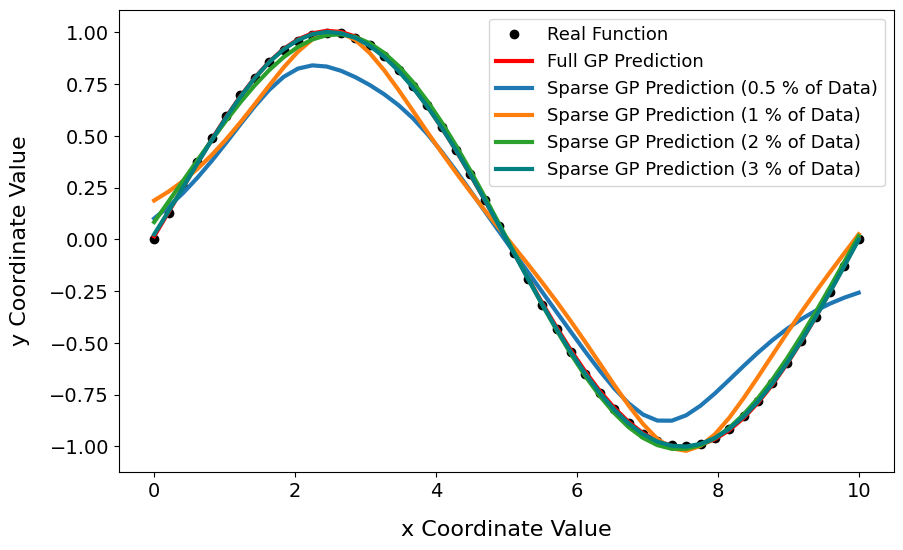

In [ ]:
#Dibujamos las predicciones junto con la función real
plt.figure(figsize=(10,6))
plt.plot(x_test.numpy(),test_y.numpy(),'o',color='black',label='Real Function',linewidth=3)
plt.plot(x_test.numpy(),preds.numpy(),color='red',label='Full GP Prediction',linewidth=3)
plt.plot(x_test.numpy(),preds_2.numpy(),label='Sparse GP Prediction (0.5 % of Data)',linewidth=3)
plt.plot(x_test.numpy(),preds_3.numpy(),label='Sparse GP Prediction (1 % of Data)',linewidth=3)
plt.plot(x_test.numpy(),preds_4.numpy(),label='Sparse GP Prediction (2 % of Data)',linewidth=3)
plt.plot(x_test.numpy(),preds_5.numpy(),color='teal',label='Sparse GP Prediction (3 % of Data)',linewidth=3)
plt.xlabel('x Coordinate Value',fontsize=16,labelpad=14)
plt.ylabel('y Coordinate Value',fontsize=16,labelpad=14)
plt.legend(fontsize=13)
plt.tick_params(labelsize=14)
plt.show()

## WATER MOLECULE CODE

WATER MOLECULE DATA ANALYSIS

IMPORT THE DATA

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/TFM/Agua/output_v2.csv'

#Leo ahora el archivo con los datos
df=pd.read_csv(file_path)

#Extraemos los datos necesarios
features=df[['HOH','dif_distancia']].values
labels_1=df['Energía'].values
labels_2=df['Dipole_X'].values
labels_3=df['Dipole_Y'].values

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Selecciono cada uno de los datos por separado
Angulos=features[:,0]
distancias=features[:,1]

#Ahora para los labels
Energía=labels_1
Dipole_X=labels_2
Dipole_Y=labels_3

HISTOGRAM OF VARIABLE ω

Text(0, 0.5, 'Number of Cases')

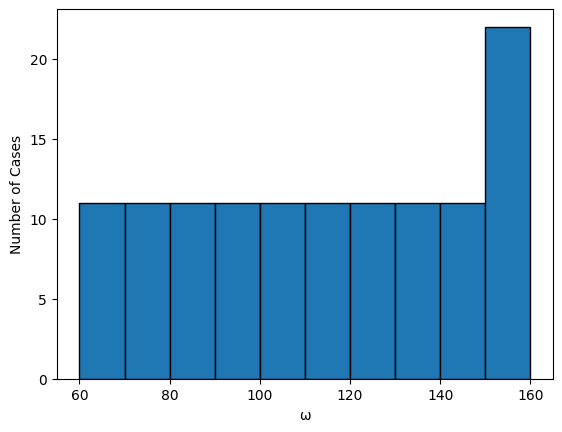

In [ ]:
plt.hist(Angulos,bins=10,edgecolor='black')
plt.xlabel('ω')
plt.ylabel('Number of Cases')

HISTOGRAM OF VARIABLE nu

Text(0, 0.5, 'Number of Cases')

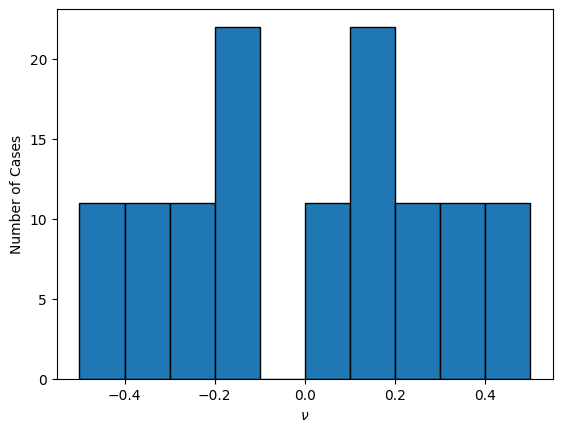

In [ ]:
plt.hist(distancias,bins=10,edgecolor='black')
plt.xlabel(r'$\nu$')
plt.ylabel('Number of Cases')

ENERGY HISTOGRAM

Text(0, 0.5, 'Number of Cases')

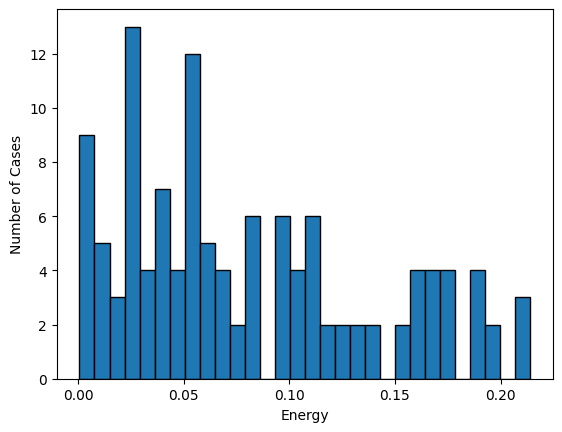

In [ ]:
plt.hist(Energía,bins=30,edgecolor='black')
plt.xlabel('Energy')
plt.ylabel('Number of Cases')

HISTOGRAM OF DIPOLE MOMENT X-AXIS

Text(0, 0.5, 'Number of Cases')

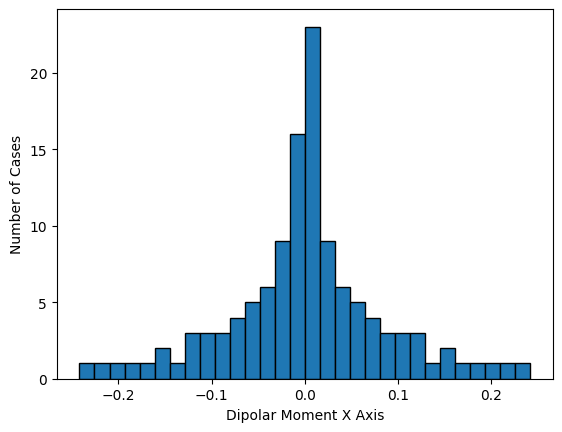

In [ ]:
plt.hist(Dipole_X,bins=30,edgecolor='black')
plt.xlabel('Dipolar Moment X Axis')
plt.ylabel('Number of Cases')

HISTOGRAM OF DIPOLE MOMENT Y-AXIS

Text(0, 0.5, 'Number of Cases')

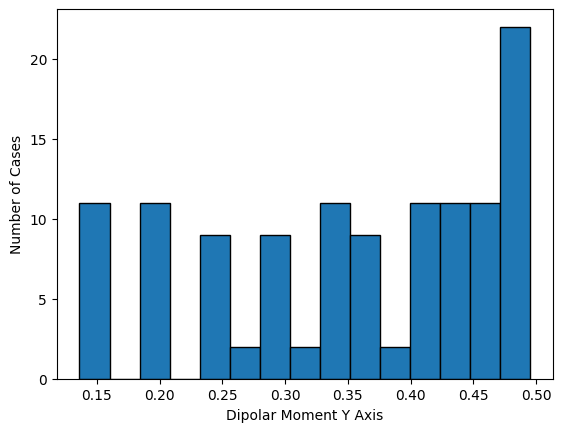

In [ ]:
plt.hist(Dipole_Y,bins=15,edgecolor='black')
plt.xlabel('Dipolar Moment Y Axis')
plt.ylabel('Number of Cases')

ENERGY RESULTS

In [ ]:
import pandas as pd

drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/TFM/Agua/output_v2.csv'

#Leo ahora el archivo con los datos
df=pd.read_csv(file_path)

#Extraemos los datos necesarios
features = df[['HOH','dif_distancia']].values
labels=df['Energía'].values

#Con el valor de energía malo dropeado
df_2=df.drop(index=0)
features_2=df_2[['HOH','dif_distancia']].values
labels_2=df_2['Energía'].values

Mounted at /content/drive


In [ ]:
from sklearn.model_selection import train_test_split

#Normalizar las características
x_data=torch.tensor(features,dtype=torch.float32)
y_data=torch.tensor(labels,dtype=torch.float32)
print(x_data.shape)

#Dividimos los datos en un split para el entrenamiento y otro para el testeo
x_train,x_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=42)

scaler=StandardScaler()
train_scaled=scaler.fit_transform(x_train)
test_scaled=scaler.transform(x_test)
x_train=torch.tensor(train_scaled,dtype=torch.float32)
x_test=torch.tensor(test_scaled,dtype=torch.float32)

scaler_y=StandardScaler()
y_train=torch.tensor(scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1),dtype=torch.float32)

torch.Size([121, 2])


In [ ]:
class GPModel(ExactGP):
    def __init__(self,train_x,train_y,likelihood):
        super(GPModel, self).__init__(train_x,train_y,likelihood)
        self.mean_module=gpytorch.means.ConstantMean()
        self.covar_module=gpytorch.kernels.ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x=self.mean_module(x)
        covar_x=self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [ ]:
class GPTmodel_2(ExactGP):
  def __init__(self,train_x,train_y,likelihood,nu):
    super(GPTmodel_2,self).__init__(train_x,train_y,likelihood)
    self.mean_module=gpytorch.means.ConstantMean()
    self.covar_module=gpytorch.kernels.ScaleKernel(MaternKernel(nu=nu))

  def forward(self, x):
    mean_x = self.mean_module(x)
    covar_x = self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [ ]:
def train_model(model,likelihood,num_epochs,lr,x_train,y_train):
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params+likelihood_params))
  optimizer=torch.optim.Adam(all_params,lr=lr)
  mll=gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)
  #Defino las listas dónde voy a guardar la pérdida y las épocas de entrenamiento
  epocas=[]
  perdida=[]
  #Inicializo el entrenamiento del modelo y el likelihood
  model.train()
  likelihood.train()
  #Empiezo el entrenamiento
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    loss=-mll(output,y_train)
    loss.backward()
    optimizer.step()
    #Guardo los parámetros de pérdida y épocas
    perdida.append(loss.item())
    epocas.append(i+1)
  return epocas,likelihood,perdida,model

In [ ]:
def evaluate_model(model,likelihood,x_test):
  model.eval()
  likelihood.eval()
  with torch.no_grad():
    test_preds=likelihood(model(x_test))
    preds=test_preds.mean
    var=test_preds.variance
  return preds,var

In [ ]:
#Defino los likelihoods
likelihood=gpytorch.likelihoods.GaussianLikelihood()
likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
likelihood_4=gpytorch.likelihoods.GaussianLikelihood()

#Me defino los modelos que quiero para el momento en X
modelo_lineal=GPModel(x_train,y_train,likelihood)
modelo_matern=GPTmodel_2(x_train,y_train,likelihood_2,0.5)
modelo_matern_2=GPTmodel_2(x_train,y_train,likelihood_3,1.5)
modelo_matern_3=GPTmodel_2(x_train,y_train,likelihood_4,2.5)

#Número total de épocas
N_epocas=600

#Defino el lr
lr=0.1

#Entreno los modelos
epocas_1,likelihood,perdida_1,modelo_lineal=train_model(modelo_lineal,likelihood,N_epocas,lr,x_train,y_train)
epocas_2,likelihood_2,perdida_2,modelo_matern=train_model(modelo_matern,likelihood_2,N_epocas,lr,x_train,y_train)
epocas_3,likelihood_3,perdida_3,modelo_matern_2=train_model(modelo_matern_2,likelihood_3,N_epocas,lr,x_train,y_train)
epocas_4,likelihood_4,perdida_4,modelo_matern_3=train_model(modelo_matern_3,likelihood_4,N_epocas,lr,x_train,y_train)

#Evaluamos ahora los resultados del test
preds_1,var_1=evaluate_model(modelo_lineal,likelihood,x_test)
preds_2,var_2=evaluate_model(modelo_matern,likelihood_2,x_test)
preds_3,var_3=evaluate_model(modelo_matern_2,likelihood_3,x_test)
preds_4,var_4=evaluate_model(modelo_matern_3,likelihood_4,x_test)

#Deshago el escalado
preds_1=scaler_y.inverse_transform(preds_1.reshape(-1,1)).reshape(-1)
preds_2=scaler_y.inverse_transform(preds_2.reshape(-1,1)).reshape(-1)
preds_3=scaler_y.inverse_transform(preds_3.reshape(-1,1)).reshape(-1)
preds_4=scaler_y.inverse_transform(preds_4.reshape(-1,1)).reshape(-1)

CODE TO ADJUST THE GRAPH FORMAT

In [ ]:
from matplotlib.ticker import FuncFormatter

def format_3_decimals(x, _):
    return f'{x:.2f}'

formatter = FuncFormatter(format_3_decimals)

RBF KERNEL RESULTS

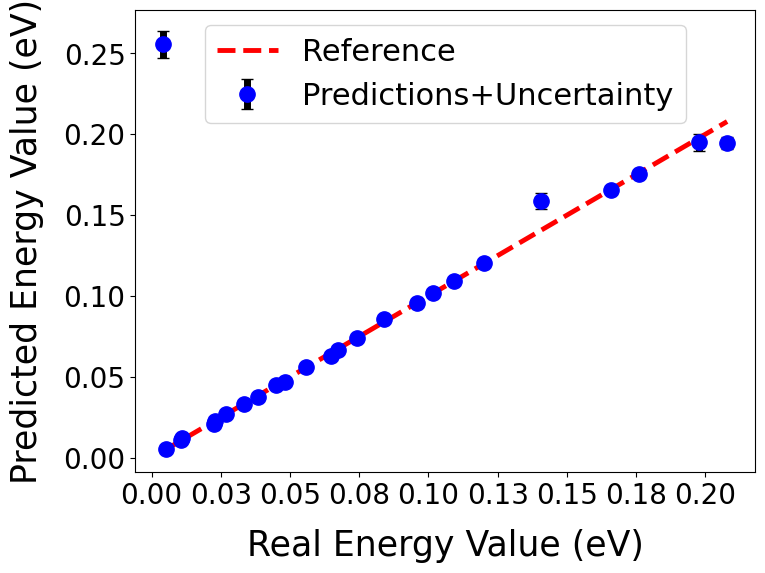

In [ ]:
std_1=var_1.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_1=std_1*sigma_y
plt.figure(figsize=(8, 6))
plt.errorbar(
    y_test,
    preds_1,
    yerr=std_1,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=5,
    capsize=4,
    markersize=11,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Reference',linewidth=3.5)
plt.xlabel('Real Energy Value (eV)',fontsize=25,labelpad=14)
plt.ylabel('Predicted Energy Value (eV)',fontsize=25,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=22)
plt.show()

MATERN KERNEL nu=0.5 RESULTS

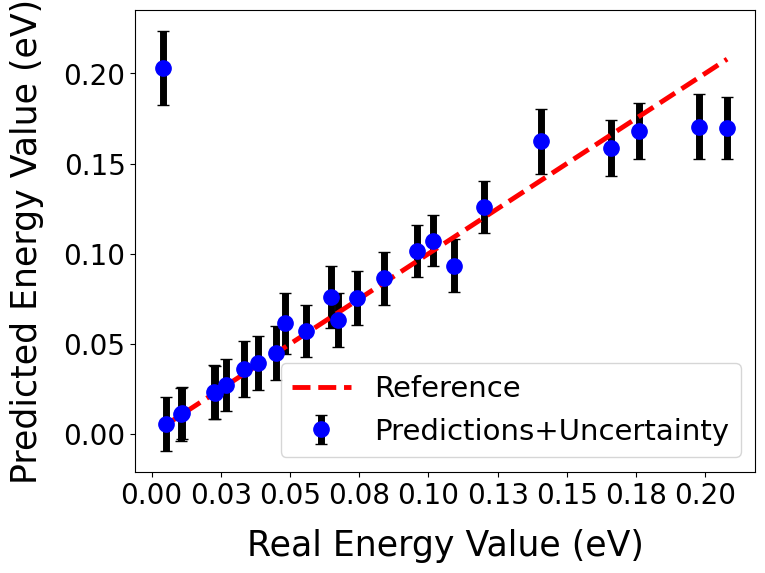

In [ ]:
std_2=var_2.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_2=std_2*sigma_y
plt.figure(figsize=(8, 6))
plt.errorbar(
    y_test,
    preds_2,
    yerr=std_2,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=5,
    capsize=4,
    markersize=11,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Reference',linewidth=3.5)
plt.xlabel('Real Energy Value (eV)',fontsize=25,labelpad=14)
plt.ylabel('Predicted Energy Value (eV)',fontsize=25,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=21)
plt.show()

MATERN KERNEL nu=1.5 RESULTS

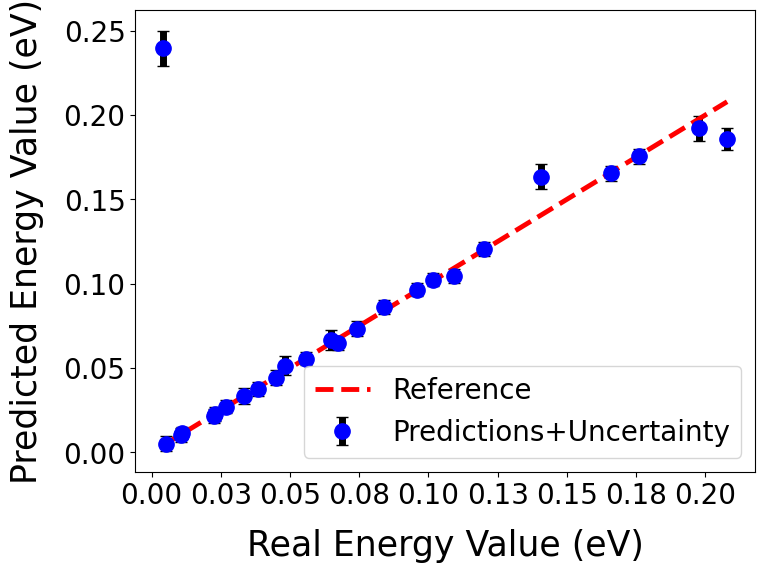

In [ ]:
std_3=var_3.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_3=std_3*sigma_y
plt.figure(figsize=(8, 6))

plt.errorbar(
    y_test,
    preds_3,
    yerr=std_3,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=5,
    capsize=4,
    markersize=11,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Reference',linewidth=3.5)
plt.xlabel('Real Energy Value (eV)',fontsize=25,labelpad=14)
plt.ylabel('Predicted Energy Value (eV)',fontsize=25,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.show()

MATERN KERNEL nu=2.5 RESULTS

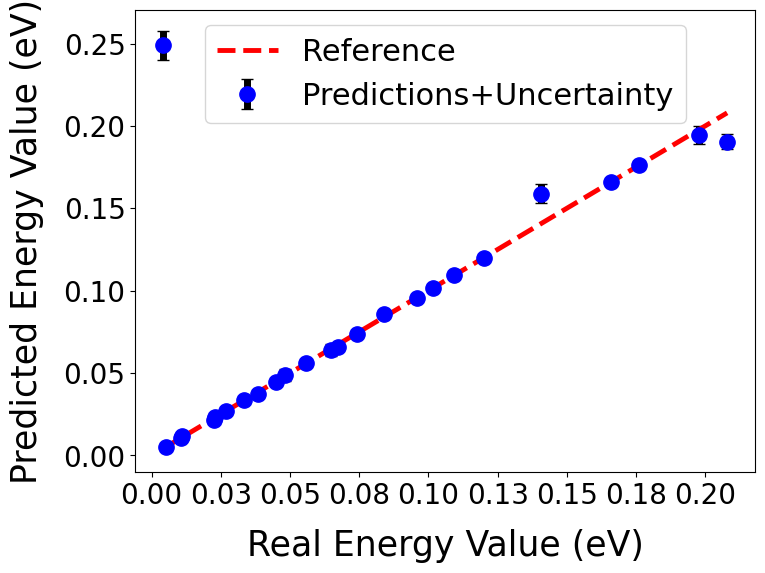

In [ ]:
std_4=var_4.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_4=std_4*sigma_y
plt.figure(figsize=(8, 6))
plt.errorbar(
    y_test,
    preds_4,
    yerr=std_4,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=5,
    capsize=4,
    markersize=11,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Reference',linewidth=3.5)
plt.xlabel('Real Energy Value (eV)',fontsize=25,labelpad=14)
plt.ylabel('Predicted Energy Value (eV)',fontsize=25,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=22)
plt.show()

NLML EVOLUTION DURING TRAINING

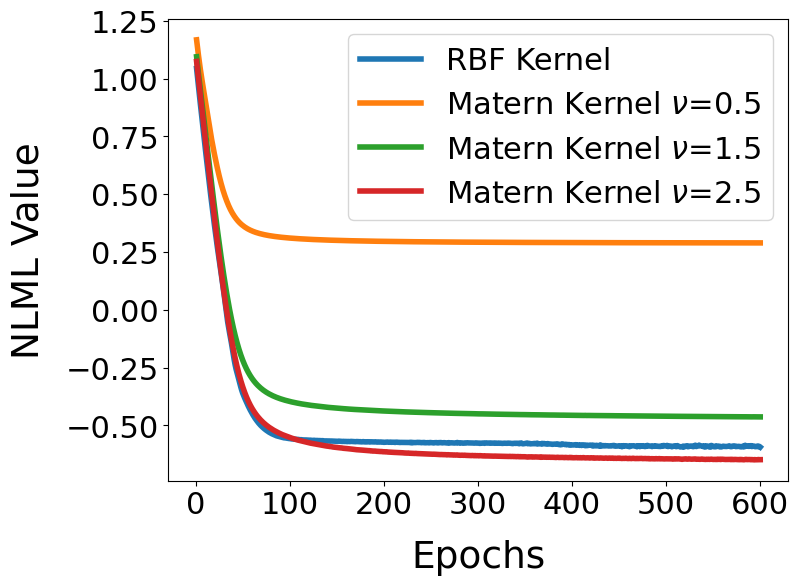

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epocas_1,perdida_1,label='RBF Kernel',linewidth=4)
plt.plot(epocas_2,perdida_2,label=r'Matern Kernel $\nu$=0.5',linewidth=4)
plt.plot(epocas_3,perdida_3,label=r'Matern Kernel $\nu$=1.5',linewidth=4)
plt.plot(epocas_4,perdida_4,label=r'Matern Kernel $\nu$=2.5',linewidth=4)
plt.xlabel('Epochs',fontsize=27,labelpad=14)
plt.ylabel('NLML Value',fontsize=27,labelpad=14)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=22)
plt.show()

CALCULATION OF MSE AND R² COEFFICIENTS

In [ ]:
preds_1=torch.tensor(preds_1,dtype=torch.float32)
preds_2=torch.tensor(preds_2,dtype=torch.float32)
preds_3=torch.tensor(preds_3,dtype=torch.float32)
preds_4=torch.tensor(preds_4,dtype=torch.float32)
y_test=torch.tensor(y_test,dtype=torch.float32)

mse_1=torch.nn.functional.mse_loss(preds_1,y_test)
mse_2=torch.nn.functional.mse_loss(preds_2,y_test)
mse_3=torch.nn.functional.mse_loss(preds_3,y_test)
mse_4=torch.nn.functional.mse_loss(preds_4,y_test)

r_1=r2_score(y_test.numpy(),preds_1.numpy())
r_2=r2_score(y_test.numpy(),preds_2.numpy())
r_3=r2_score(y_test.numpy(),preds_3.numpy())
r_4=r2_score(y_test.numpy(),preds_4.numpy())

print(f"MSE del modelo RBF: {mse_1.item()}")
print(f"MSE del modelo Matern: {mse_2.item()}")
print(f"MSE del modelo Matern 2: {mse_3.item()}")
print(f"MSE del modelo Matern 3: {mse_4.item()}")

print(f"R2 del modelo RBF: {r_1}")
print(f"R2 del modelo Matern: {r_2}")
print(f"R2 del modelo Matern 2: {r_3}")
print(f"R2 del modelo Matern 3: {r_4}")

MSE del modelo RBF: 0.0025484254583716393
MSE del modelo Matern: 0.0017218503635376692
MSE del modelo Matern 2: 0.0022579494398087263
MSE del modelo Matern 3: 0.0024218035396188498
R2 del modelo RBF: 0.30002039670944214
R2 del modelo Matern: 0.5270568132400513
R2 del modelo Matern 2: 0.3798058032989502
R2 del modelo Matern 3: 0.33479976654052734


<ipython-input-10-25285140>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test=torch.tensor(y_test,dtype=torch.float32)


CALCULATION OF MSE AND R² COEFFICIENTS WITHOUT THE OUTLIER

In [ ]:
#Elimino el elemento en la posición 18 que es el que sale mal (pred=0.235, real=0.0043)
preds_1_act=np.delete(preds_1,17)
preds_2_act=np.delete(preds_2,17)
preds_3_act=np.delete(preds_3,17)
preds_4_act=np.delete(preds_4,17)
y_test_act=np.delete(y_test,17)

#Convierto a tensores
preds_1_act=torch.tensor(preds_1_act,dtype=torch.float32)
preds_2_act=torch.tensor(preds_2_act,dtype=torch.float32)
preds_3_act=torch.tensor(preds_3_act,dtype=torch.float32)
preds_4_act=torch.tensor(preds_4_act,dtype=torch.float32)
y_test_act=torch.tensor(y_test_act,dtype=torch.float32)

<ipython-input-11-738454018>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_1_act=torch.tensor(preds_1_act,dtype=torch.float32)
<ipython-input-11-738454018>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_2_act=torch.tensor(preds_2_act,dtype=torch.float32)
<ipython-input-11-738454018>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_3_act=torch.tensor(preds_3_act,dtype=torch.float32)
<ipython-input-11-738454018>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() 

In [ ]:
#Calculo ahora los coeficientes y el MSE actualizado sin el punto
mse_1=torch.nn.functional.mse_loss(preds_1_act,y_test_act)
mse_2=torch.nn.functional.mse_loss(preds_2_act,y_test_act)
mse_3=torch.nn.functional.mse_loss(preds_3_act,y_test_act)
mse_4=torch.nn.functional.mse_loss(preds_4_act,y_test_act)

r_1=r2_score(y_test_act.numpy(),preds_1_act.numpy())
r_2=r2_score(y_test_act.numpy(),preds_2_act.numpy())
r_3=r2_score(y_test_act.numpy(),preds_3_act.numpy())
r_4=r2_score(y_test_act.numpy(),preds_4_act.numpy())

print(f"MSE del modelo RBF: {mse_1.item()}")
print(f"MSE del modelo Matern: {mse_2.item()}")
print(f"MSE del modelo Matern 2: {mse_3.item()}")
print(f"MSE del modelo Matern 3: {mse_4.item()}")

print(f"R2 del modelo RBF: {r_1}")
print(f"R2 del modelo Matern: {r_2}")
print(f"R2 del modelo Matern 2: {r_3}")
print(f"R2 del modelo Matern 3: {r_4}")

MSE del modelo RBF: 2.2043421267881058e-05
MSE del modelo Matern: 0.0001454724551877007
MSE del modelo Matern 2: 4.56187262898311e-05
MSE del modelo Matern 3: 2.7506999686011113e-05
R2 del modelo RBF: 0.9938111305236816
R2 del modelo Matern: 0.9591573476791382
R2 del modelo Matern 2: 0.9871921539306641
R2 del modelo Matern 3: 0.9922771453857422


EVOLUTION OF THE R² COEFFICIENT WITH THE SIZE OF THE TRAINING DATASET (WITH THE OUTLIER)

In [ ]:
tamaño_dataset=[0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

#Defino el learning rate y el número de épocas de entrenamiento
num_epocas=600
lr=0.1

#Ahora inicio listas para guardar los datos
r_Full_RBF=[]
r_Full_Matern_1=[]
r_Full_Matern_2=[]
r_Full_Matern_3=[]

for tamaño in tamaño_dataset:
  x_data=torch.tensor(features,dtype=torch.float32)
  y_data=torch.tensor(labels,dtype=torch.float32)
  Energy_train,Energy_test,y_train,y_test=train_test_split(x_data,y_data,train_size=tamaño,random_state=42)

  scaler=StandardScaler()
  Energy_train_scaled=scaler.fit_transform(Energy_train)
  Energy_test_scaled=scaler.transform(Energy_test)
  Energy_train=torch.tensor(Energy_train_scaled,dtype=torch.float32)
  Energy_test=torch.tensor(Energy_test_scaled,dtype=torch.float32)

  #Escalado en y
  scaler_y=StandardScaler()
  y_train=scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
  y_test=scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)
  y_train=torch.tensor(y_train,dtype=torch.float32)
  y_test=torch.tensor(y_test,dtype=torch.float32)

  #Genero el primero modelo entreno y calculo el R2
  likelihood_1=gpytorch.likelihoods.GaussianLikelihood()
  model_1=GPModel(Energy_train,y_train,likelihood_1)
  epocas_1,likelihood_1,perdida_1,model_1=train_model(model_1,likelihood_1,num_epocas,lr,Energy_train,y_train)
  preds_1,_=evaluate_model(model_1,likelihood_1,Energy_test)
  r_Full_RBF.append(r2_score(y_test,preds_1))

  #Genero el segundo modelo entreno y calculo el R2
  likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
  model_2=GPTmodel_2(Energy_train,y_train,likelihood_2,0.5)
  epocas_2,likelihood_2,perdida_2,model_2=train_model(model_2,likelihood_2,num_epocas,lr,Energy_train,y_train)
  preds_2,_=evaluate_model(model_2,likelihood_2,Energy_test)
  r_Full_Matern_1.append(r2_score(y_test,preds_2))

  #Genero el tercer modelo entreno y calculo el R2
  likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
  model_3=GPTmodel_2(Energy_train,y_train,likelihood_3,1.5)
  epocas_3,likelihood_3,perdida_3,model_3=train_model(model_3,likelihood_3,num_epocas,lr,Energy_train,y_train)
  preds_3,_=evaluate_model(model_3,likelihood_3,Energy_test)
  r_Full_Matern_2.append(r2_score(y_test,preds_3))

  #Genero el cuarto modelo entreno y calculo el R2
  likelihood_4=gpytorch.likelihoods.GaussianLikelihood()
  model_4=GPTmodel_2(Energy_train,y_train,likelihood_4,2.5)
  epocas_4,likelihood_4,perdida_4,model_4=train_model(model_4,likelihood_4,num_epocas,lr,Energy_train,y_train)
  preds_4,_=evaluate_model(model_4,likelihood_4,Energy_test)
  r_Full_Matern_3.append(r2_score(y_test,preds_4))

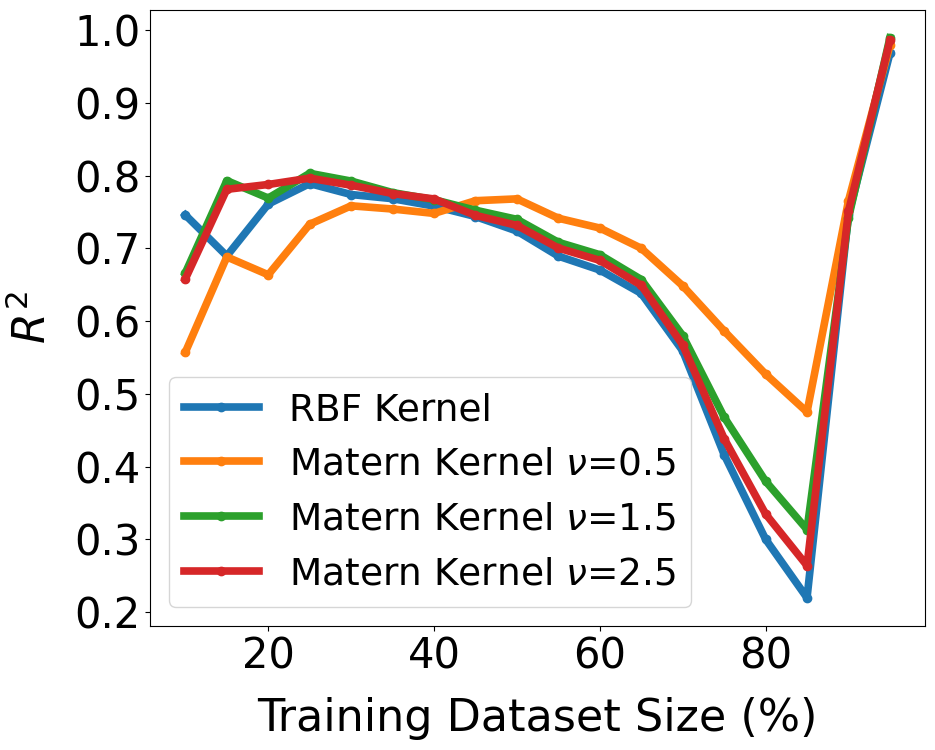

In [ ]:
dataset_size=[10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.figure(figsize=(10, 8))
plt.plot(dataset_size,r_Full_RBF,marker='o',label='RBF Kernel',linewidth=5.5)
plt.plot(dataset_size,r_Full_Matern_1,marker='o',label=r'Matern Kernel $\nu$=0.5',linewidth=5.5)
plt.plot(dataset_size,r_Full_Matern_2,marker='o',label=r'Matern Kernel $\nu$=1.5',linewidth=5.5)
plt.plot(dataset_size,r_Full_Matern_3,marker='o',label=r'Matern Kernel $\nu$=2.5',linewidth=5.5)
plt.xlabel('Training Dataset Size (%)',fontsize=32,labelpad=14)
plt.ylabel(r'$R^{2}$',fontsize=32,labelpad=14)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
#plt.title('R2 vs Dataset Size (Dipolo X)')
plt.legend(fontsize=27)
plt.show()

EVOLUTION OF THE R² COEFFICIENT WITH THE SIZE OF THE TRAINING DATASET (WITHOUT THE OUTLIER)

In [ ]:
tamaño_dataset=[0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

#Defino el learning rate y el número de épocas de entrenamiento
num_epocas=600
lr=0.1

#Ahora inicio listas para guardar los datos
r_Full_RBF=[]
r_Full_Matern_1=[]
r_Full_Matern_2=[]
r_Full_Matern_3=[]

for tamaño in tamaño_dataset:
  x_data_2=torch.tensor(features_2,dtype=torch.float32)
  y_data_2=torch.tensor(labels_2,dtype=torch.float32)
  Energy_train,Energy_test,y_train,y_test=train_test_split(x_data_2,y_data_2,train_size=tamaño,random_state=42)

  scaler=StandardScaler()
  Energy_train_scaled=scaler.fit_transform(Energy_train)
  Energy_test_scaled=scaler.transform(Energy_test)
  Energy_train=torch.tensor(Energy_train_scaled,dtype=torch.float32)
  Energy_test=torch.tensor(Energy_test_scaled,dtype=torch.float32)

  #Escalado para el eje Y
  scaler_y=StandardScaler()
  y_train=scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1)
  y_test=scaler_y.transform(y_test.reshape(-1,1)).reshape(-1)
  y_train=torch.tensor(y_train,dtype=torch.float32)
  y_test=torch.tensor(y_test,dtype=torch.float32)

  #Genero el primero modelo entreno y calculo el R2
  likelihood_1=gpytorch.likelihoods.GaussianLikelihood()
  model_1=GPModel(Energy_train,y_train,likelihood_1)
  epocas_1,likelihood_1,perdida_1,model_1=train_model(model_1,likelihood_1,num_epocas,lr,Energy_train,y_train)
  preds_1,_=evaluate_model(model_1,likelihood_1,Energy_test)
  r_Full_RBF.append(r2_score(y_test,preds_1))

  #Genero el segundo modelo entreno y calculo el R2
  likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
  model_2=GPTmodel_2(Energy_train,y_train,likelihood_2,0.5)
  epocas_2,likelihood_2,perdida_2,model_2=train_model(model_2,likelihood_2,num_epocas,lr,Energy_train,y_train)
  preds_2,_=evaluate_model(model_2,likelihood_2,Energy_test)
  r_Full_Matern_1.append(r2_score(y_test,preds_2))

  #Genero el tercer modelo entreno y calculo el R2
  likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
  model_3=GPTmodel_2(Energy_train,y_train,likelihood_3,1.5)
  epocas_3,likelihood_3,perdida_3,model_3=train_model(model_3,likelihood_3,num_epocas,lr,Energy_train,y_train)
  preds_3,_=evaluate_model(model_3,likelihood_3,Energy_test)
  r_Full_Matern_2.append(r2_score(y_test,preds_3))

  #Genero el cuarto modelo entreno y calculo el R2
  likelihood_4=gpytorch.likelihoods.GaussianLikelihood()
  model_4=GPTmodel_2(Energy_train,y_train,likelihood_4,2.5)
  epocas_4,likelihood_4,perdida_4,model_4=train_model(model_4,likelihood_4,num_epocas,lr,Energy_train,y_train)
  preds_4,_=evaluate_model(model_4,likelihood_4,Energy_test)
  r_Full_Matern_3.append(r2_score(y_test,preds_4))

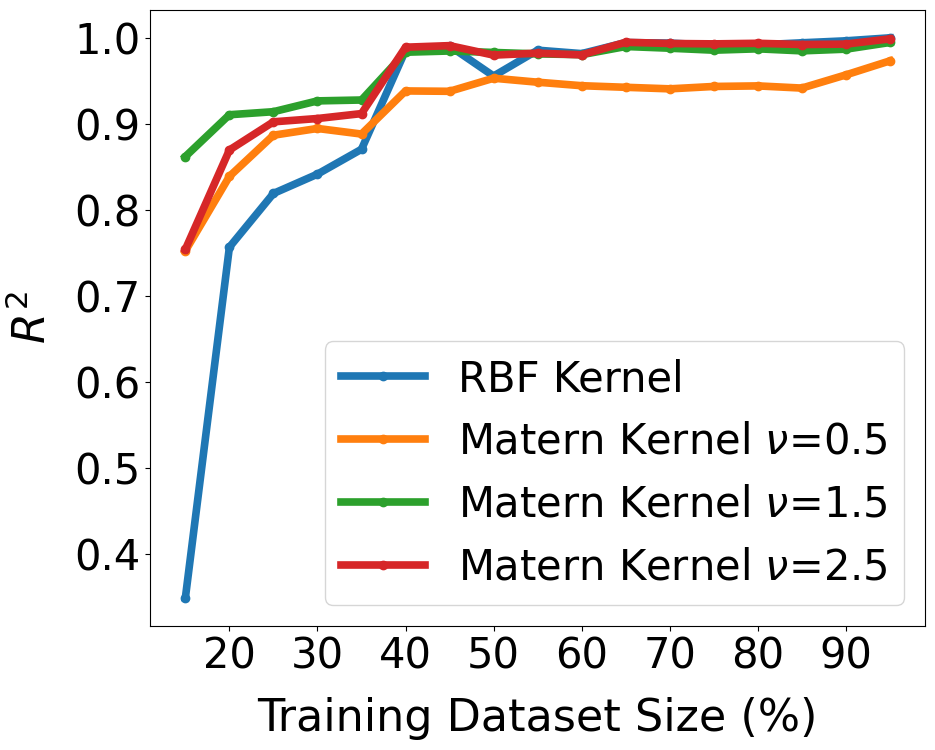

In [ ]:
dataset_size=[15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.figure(figsize=(10, 8))
plt.plot(dataset_size,r_Full_RBF,marker='o',label='RBF Kernel',linewidth=5.5)
plt.plot(dataset_size,r_Full_Matern_1,marker='o',label=r'Matern Kernel $\nu$=0.5',linewidth=5.5)
plt.plot(dataset_size,r_Full_Matern_2,marker='o',label=r'Matern Kernel $\nu$=1.5',linewidth=5.5)
plt.plot(dataset_size,r_Full_Matern_3,marker='o',label=r'Matern Kernel $\nu$=2.5',linewidth=5.5)
plt.xlabel('Training Dataset Size (%)',fontsize=32,labelpad=14)
plt.ylabel(r'$R^{2}$',fontsize=32,labelpad=14)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
plt.show()

RESULTS DIPOLAR MOMENT X-AXIS

In [ ]:
#Vamos a importar ahora los datos necesarios
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path='/content/drive/MyDrive/Colab Notebooks/TFM/Agua/output_v2.csv'

#Leo ahora el archivo con los datos
df=pd.read_csv(file_path)

#Extraemos los datos necesarios
features=df[['HOH','dif_distancia']].values
labels=df[['Dipole_X','Dipole_Y']]
Dipole_X=df['Dipole_X'].values
Dipole_Y=df['Dipole_Y'].values

Mounted at /content/drive


In [ ]:
#Adaptamos ahora los datos para poder utilizarlos en el modelo
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

x_data=torch.tensor(features,dtype=torch.float32)
y_data=torch.tensor(labels.values,dtype=torch.float32)

#Dividimos los datos en un split para el entrenamiento y otro para el testeo
Dipole_train,Dipole_test,y_train,y_test=train_test_split(x_data,y_data,test_size=0.2,random_state=42)
y_train_1=y_train[:,0]
y_train_2=y_train[:,1]
y_test_1=y_test[:,0]
y_test_2=y_test[:,1]

scaler=StandardScaler()
Dipole_train_scaled=scaler.fit_transform(Dipole_train)
Dipole_test_scaled=scaler.transform(Dipole_test)
Dipole_train=torch.tensor(Dipole_train_scaled,dtype=torch.float32)
Dipole_test=torch.tensor(Dipole_test_scaled,dtype=torch.float32)

#Escalado en y_1
scaler_y=StandardScaler()
y_train_1_scaled=scaler_y.fit_transform(y_train_1.reshape(-1,1)).reshape(-1)
y_train_1=torch.tensor(y_train_1_scaled,dtype=torch.float32)
y_test_1=torch.tensor(y_test_1,dtype=torch.float32)

#Escalado en y_2
scaler_y_2=StandardScaler()
y_train_2_scaled=scaler_y_2.fit_transform(y_train_2.reshape(-1, 1)).reshape(-1)
y_train_2=torch.tensor(y_train_2_scaled,dtype=torch.float32)
y_test_2=torch.tensor(y_test_2,dtype=torch.float32)

/tmp/ipython-input-3-2456581194.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_1=torch.tensor(y_test_1,dtype=torch.float32)
/tmp/ipython-input-3-2456581194.py:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_2=torch.tensor(y_test_2,dtype=torch.float32)


In [ ]:
class GPModel(ExactGP):
    def __init__(self,train_x,train_y,likelihood):
        super(GPModel, self).__init__(train_x,train_y,likelihood)
        self.mean_module=gpytorch.means.ConstantMean()
        self.covar_module=gpytorch.kernels.ScaleKernel(RBFKernel())

    def forward(self, x):
        mean_x=self.mean_module(x)
        covar_x=self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [ ]:
class GPTmodel_2(ExactGP):
  def __init__(self,train_x,train_y,likelihood,nu):
    super(GPTmodel_2,self).__init__(train_x,train_y,likelihood)
    self.mean_module=gpytorch.means.ConstantMean()
    self.covar_module=gpytorch.kernels.ScaleKernel(MaternKernel(nu=nu))

  def forward(self, x):
    mean_x=self.mean_module(x)
    covar_x=self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

In [ ]:
def train_model(model,likelihood,num_epochs,lr,x_train,y_train):
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params+likelihood_params))
  optimizer=torch.optim.Adam(all_params,lr=lr)
  mll=gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)
  #Defino las listas dónde voy a guardar la pérdida y las épocas de entrenamiento
  epocas=[]
  perdida=[]
  #Inicializo el entrenamiento del modelo y el likelihood
  model.train()
  likelihood.train()
  #Empiezo el entrenamiento
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    loss=-mll(output,y_train)
    loss.backward()
    optimizer.step()
    #Guardo los parámetros de pérdida y épocas
    perdida.append(loss.item())
    epocas.append(i+1)
  return epocas,likelihood,perdida,model

In [ ]:
def evaluate_model(model,likelihood,x_test):
  model.eval()
  likelihood.eval()
  with torch.no_grad():
    test_preds=likelihood(model(x_test))
  preds=test_preds.mean
  var=test_preds.variance
  return preds,var

In [ ]:
#Defino los likelihoods
likelihood=gpytorch.likelihoods.GaussianLikelihood()
likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
likelihood_4=gpytorch.likelihoods.GaussianLikelihood()

#Me defino los modelos que quiero para el momento en X
modelo_lineal=GPModel(Dipole_train,y_train_1,likelihood)
modelo_matern=GPTmodel_2(Dipole_train,y_train_1,likelihood_2,0.5)
modelo_matern_2=GPTmodel_2(Dipole_train,y_train_1,likelihood_3,1.5)
modelo_matern_3=GPTmodel_2(Dipole_train,y_train_1,likelihood_4,2.5)

#Número total de épocas
N_epocas=600

#Defino el lr
lr=0.1

#Entreno los modelos
epocas_1,likelihood,perdida_1,modelo_lineal=train_model(modelo_lineal,likelihood,N_epocas,lr,Dipole_train,y_train_1)
epocas_2,likelihood_2,perdida_2,modelo_matern=train_model(modelo_matern,likelihood_2,N_epocas,lr,Dipole_train,y_train_1)
epocas_3,likelihood_3,perdida_3,modelo_matern_2=train_model(modelo_matern_2,likelihood_3,N_epocas,lr,Dipole_train,y_train_1)
epocas_4,likelihood_4,perdida_4,modelo_matern_3=train_model(modelo_matern_3,likelihood_4,N_epocas,lr,Dipole_train,y_train_1)

#Evaluamos el funcionamiento del modelo
preds_1,var_1=evaluate_model(modelo_lineal,likelihood,Dipole_test)
preds_2,var_2=evaluate_model(modelo_matern,likelihood_2,Dipole_test)
preds_3,var_3=evaluate_model(modelo_matern_2,likelihood_3,Dipole_test)
preds_4,var_4=evaluate_model(modelo_matern_3,likelihood_4,Dipole_test)

#Deshago las predicciones y tests
preds_1=preds_1.reshape(-1,1)
preds_1=scaler_y.inverse_transform(preds_1).reshape(-1)
preds_1=torch.tensor(preds_1,dtype=torch.float32)

preds_2=preds_2.reshape(-1,1)
preds_2=scaler_y.inverse_transform(preds_2).reshape(-1)
preds_2=torch.tensor(preds_2,dtype=torch.float32)

preds_3=preds_3.reshape(-1,1)
preds_3=scaler_y.inverse_transform(preds_3).reshape(-1)
preds_3=torch.tensor(preds_3,dtype=torch.float32)

preds_4=preds_4.reshape(-1,1)
preds_4=scaler_y.inverse_transform(preds_4).reshape(-1)
preds_4=torch.tensor(preds_4,dtype=torch.float32)

In [ ]:
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
def format_3_decimals(x, _):
    return f'{x:.2f}'

formatter = FuncFormatter(format_3_decimals)

RBF KERNEL RESULTS

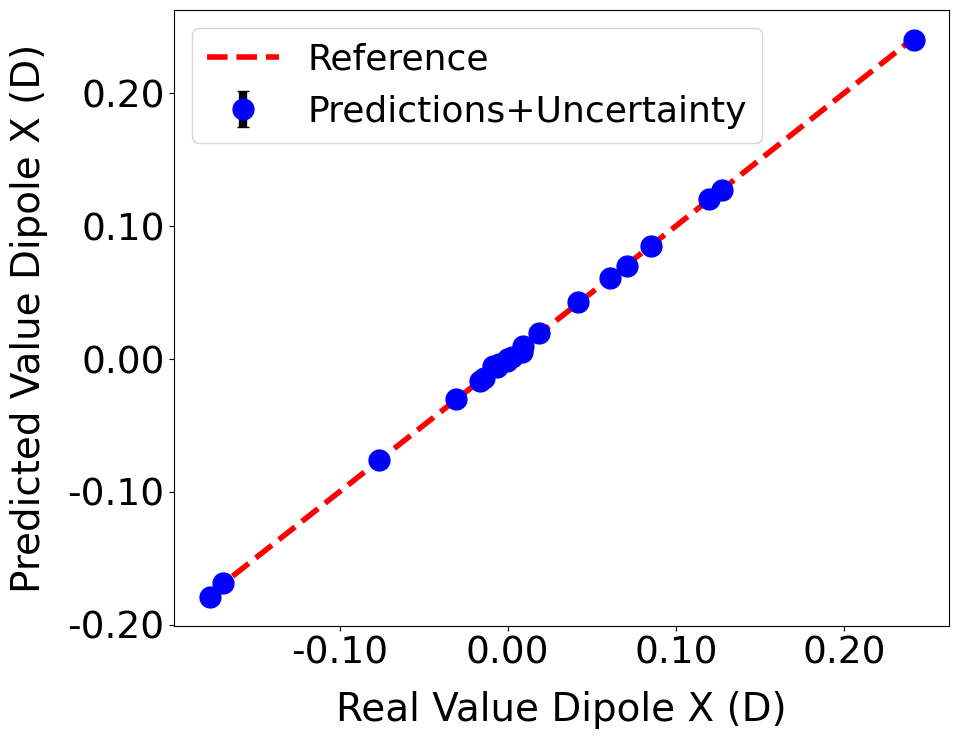

In [ ]:
std_1=var_1.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_1=std_1*sigma_y
plt.figure(figsize=(10,8))
plt.errorbar(
    y_test_1.numpy(),
    preds_1.numpy(),
    yerr=std_1,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_1.numpy()), max(y_test_1.numpy())], [min(y_test_1.numpy()), max(y_test_1.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole X (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole X (D)',fontsize=28,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=26)
plt.show()

MATERN KERNEL nu=0.5 RESULTS

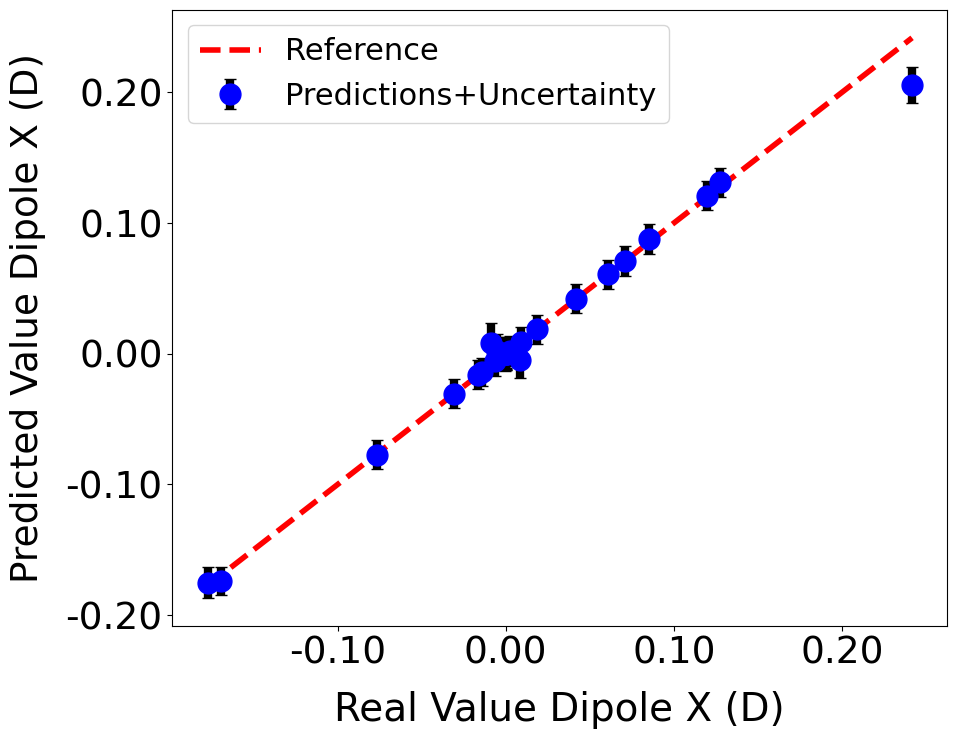

In [ ]:
std_2=var_2.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_2=std_2*sigma_y
plt.figure(figsize=(10, 8))
plt.errorbar(
    y_test_1.numpy(),
    preds_2.numpy(),
    yerr=std_2,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_1.numpy()), max(y_test_1.numpy())], [min(y_test_1.numpy()), max(y_test_1.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole X (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole X (D)',fontsize=27,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=22)
plt.show()

MATERN KERNEL nu=1.5 RESULTS

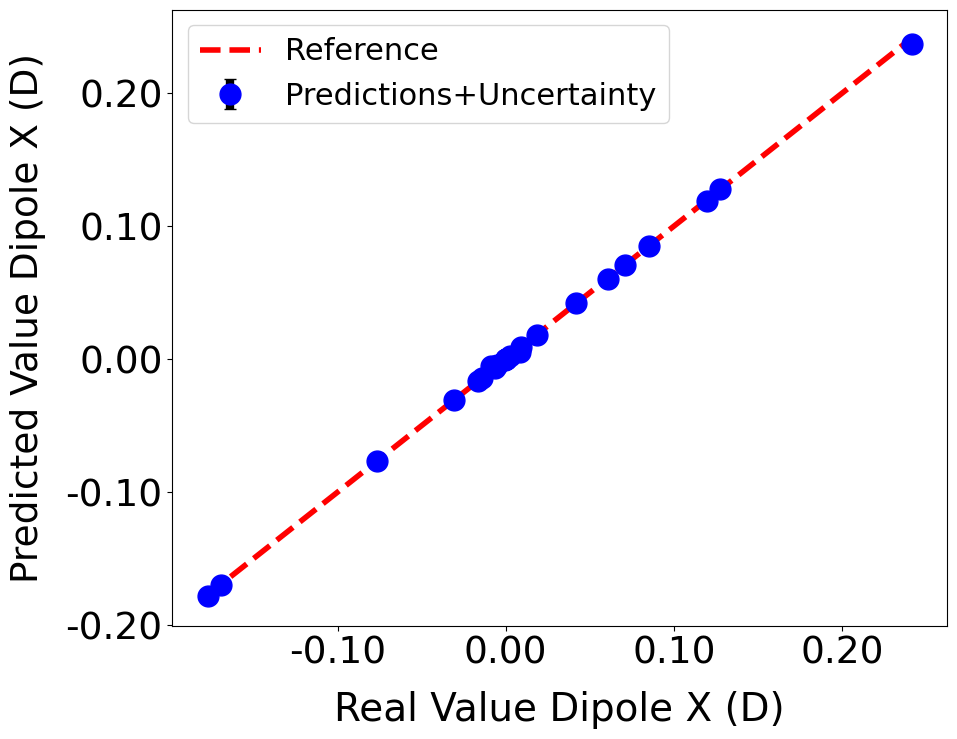

In [ ]:
std_3=var_3.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_3=std_3*sigma_y
plt.figure(figsize=(10, 8))
plt.errorbar(
    y_test_1.numpy(),
    preds_3.numpy(),
    yerr=std_3,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_1.numpy()), max(y_test_1.numpy())], [min(y_test_1.numpy()), max(y_test_1.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole X (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole X (D)',fontsize=27,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=22)
plt.show()

MATERN KERNEL nu=2.5 RESULTS

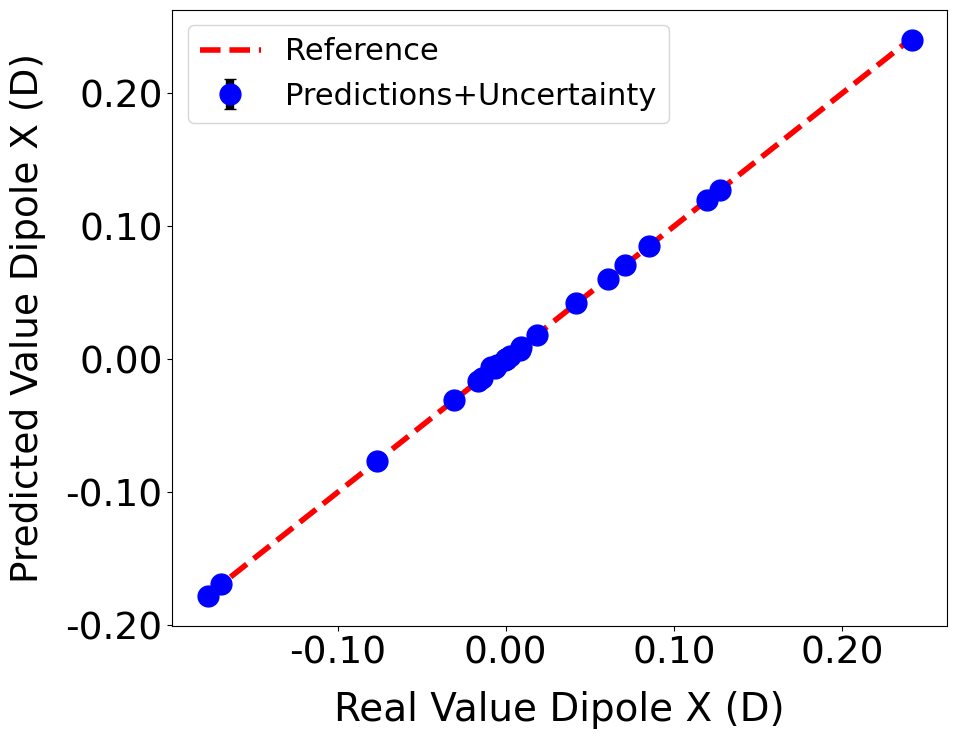

In [ ]:
std_4=var_4.sqrt().numpy()
sigma_y=scaler_y.scale_[0]
std_4=std_4*sigma_y
plt.figure(figsize=(10, 8))
plt.errorbar(
    y_test_1.numpy(),
    preds_4.numpy(),
    yerr=std_4,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_1.numpy()), max(y_test_1.numpy())], [min(y_test_1.numpy()), max(y_test_1.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole X (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole X (D)',fontsize=27,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=22)
plt.show()

NLML EVOLUTION DURING TRAINING

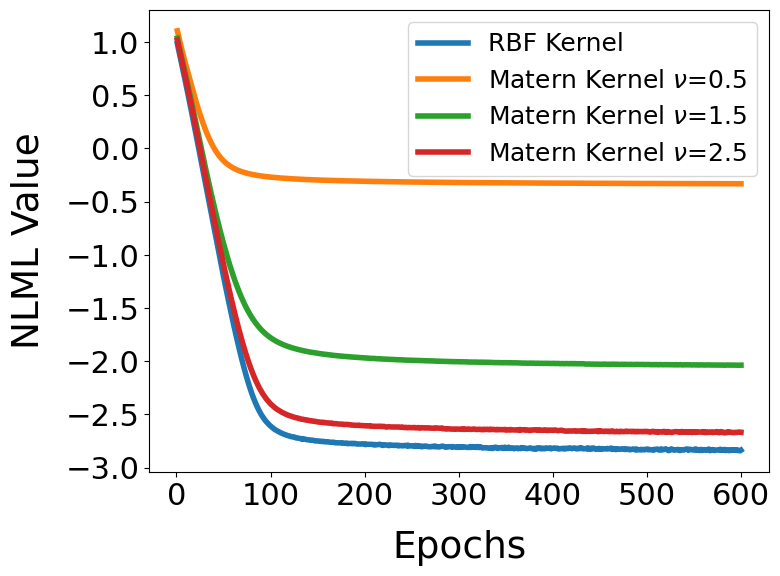

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epocas_1,perdida_1,label='RBF Kernel',linewidth=4)
plt.plot(epocas_2,perdida_2,label=r'Matern Kernel $\nu$=0.5',linewidth=4)
plt.plot(epocas_3,perdida_3,label=r'Matern Kernel $\nu$=1.5',linewidth=4)
plt.plot(epocas_4,perdida_4,label=r'Matern Kernel $\nu$=2.5',linewidth=4)
plt.xlabel('Epochs',fontsize=27,labelpad=14)
plt.ylabel('NLML Value',fontsize=27,labelpad=14)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=18)
plt.show()

EVALUATION OF MSE AND R² COEFFICIENT

In [ ]:
mse_1=torch.nn.functional.mse_loss(preds_1,y_test_1)
mse_2=torch.nn.functional.mse_loss(preds_2,y_test_1)
mse_3=torch.nn.functional.mse_loss(preds_3,y_test_1)
mse_4=torch.nn.functional.mse_loss(preds_4,y_test_1)

r_1=r2_score(y_test_1.numpy(),preds_1.numpy())
r_2=r2_score(y_test_1.numpy(),preds_2.numpy())
r_3=r2_score(y_test_1.numpy(),preds_3.numpy())
r_4=r2_score(y_test_1.numpy(),preds_4.numpy())

print(f"MSE del modelo Lineal: {mse_1.item()}")
print(f"MSE del modelo Matern: {mse_2.item()}")
print(f"MSE del modelo Matern 2: {mse_3.item()}")
print(f"MSE del modelo Matern 3: {mse_4.item()}")

print(f"R2 del modelo Lineal: {r_1}")
print(f"R2 del modelo Matern: {r_2}")
print(f"R2 del modelo Matern 2: {r_3}")
print(f"R2 del modelo Matern 3: {r_4}")

MSE del modelo Lineal: 1.3383335044636624e-06
MSE del modelo Matern: 7.378218288067728e-05
MSE del modelo Matern 2: 1.695077685326396e-06
MSE del modelo Matern 3: 5.372712053031137e-07
R2 del modelo Lineal: 0.9998050928115845
R2 del modelo Matern: 0.9892560243606567
R2 del modelo Matern 2: 0.9997531771659851
R2 del modelo Matern 3: 0.9999217391014099


DIPOLAR MOMENT Y-AXIS RESULTS

In [ ]:
#Defino los likelihoods
likelihood=gpytorch.likelihoods.GaussianLikelihood()
likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
likelihood_4=gpytorch.likelihoods.GaussianLikelihood()

#Me defino los modelos que quiero para el momento en X
modelo_lineal=GPModel(Dipole_train,y_train_2,likelihood)
modelo_matern=GPTmodel_2(Dipole_train,y_train_2,likelihood_2,0.5)
modelo_matern_2=GPTmodel_2(Dipole_train,y_train_2,likelihood_3,1.5)
modelo_matern_3=GPTmodel_2(Dipole_train,y_train_2,likelihood_4,2.5)

#Número total de épocas
N_epocas=600

#Defino el lr
lr=0.1

#Entreno los modelos
epocas_1,likelihood,perdida_1,modelo_lineal=train_model(modelo_lineal,likelihood,N_epocas,lr,Dipole_train,y_train_2)
epocas_2,likelihood_2,perdida_2,modelo_matern=train_model(modelo_matern,likelihood_2,N_epocas,lr,Dipole_train,y_train_2)
epocas_3,likelihood_3,perdida_3,modelo_matern_2=train_model(modelo_matern_2,likelihood_3,N_epocas,lr,Dipole_train,y_train_2)
epocas_4,likelihood_4,perdida_4,modelo_matern_3=train_model(modelo_matern_3,likelihood_4,N_epocas,lr,Dipole_train,y_train_2)

#Evaluamos el funcionamiento del modelo
preds_5,var_5=evaluate_model(modelo_lineal,likelihood,Dipole_test)
preds_6,var_6=evaluate_model(modelo_matern,likelihood_2,Dipole_test)
preds_7,var_7=evaluate_model(modelo_matern_2,likelihood_3,Dipole_test)
preds_8,var_8=evaluate_model(modelo_matern_3,likelihood_4,Dipole_test)

#Deshago el escalado
preds_5=preds_5.reshape(-1,1)
preds_5=scaler_y_2.inverse_transform(preds_5).reshape(-1)
preds_5=torch.tensor(preds_5,dtype=torch.float32)

preds_6=preds_6.reshape(-1,1)
preds_6=scaler_y_2.inverse_transform(preds_6).reshape(-1)
preds_6=torch.tensor(preds_6,dtype=torch.float32)

preds_7=preds_7.reshape(-1,1)
preds_7=scaler_y_2.inverse_transform(preds_7).reshape(-1)
preds_7=torch.tensor(preds_7,dtype=torch.float32)

preds_8=preds_8.reshape(-1,1)
preds_8=scaler_y_2.inverse_transform(preds_8).reshape(-1)
preds_8=torch.tensor(preds_8,dtype=torch.float32)

RBF KERNEL RESULTS



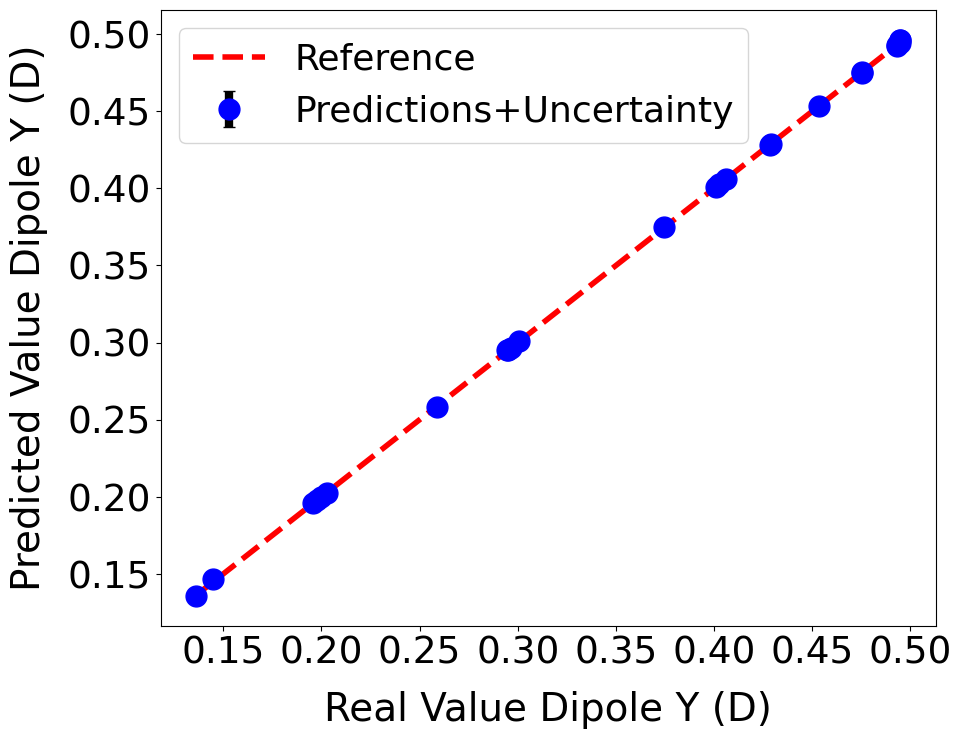

In [ ]:
std_5=var_5.sqrt().numpy()
sigma_y=scaler_y_2.scale_[0]
std_5=std_5*sigma_y
plt.figure(figsize=(10, 8))
plt.errorbar(
    y_test_2.numpy(),
    preds_5.numpy(),
    yerr=std_5,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_2.numpy()), max(y_test_2.numpy())], [min(y_test_2.numpy()), max(y_test_2.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole Y (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole Y (D)',fontsize=28,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_locator(MultipleLocator(0.08))
#ax.yaxis.set_major_locator(MultipleLocator(0.08))
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=26)
plt.show()

MATERN KERNEL nu=0.5 RESULTS

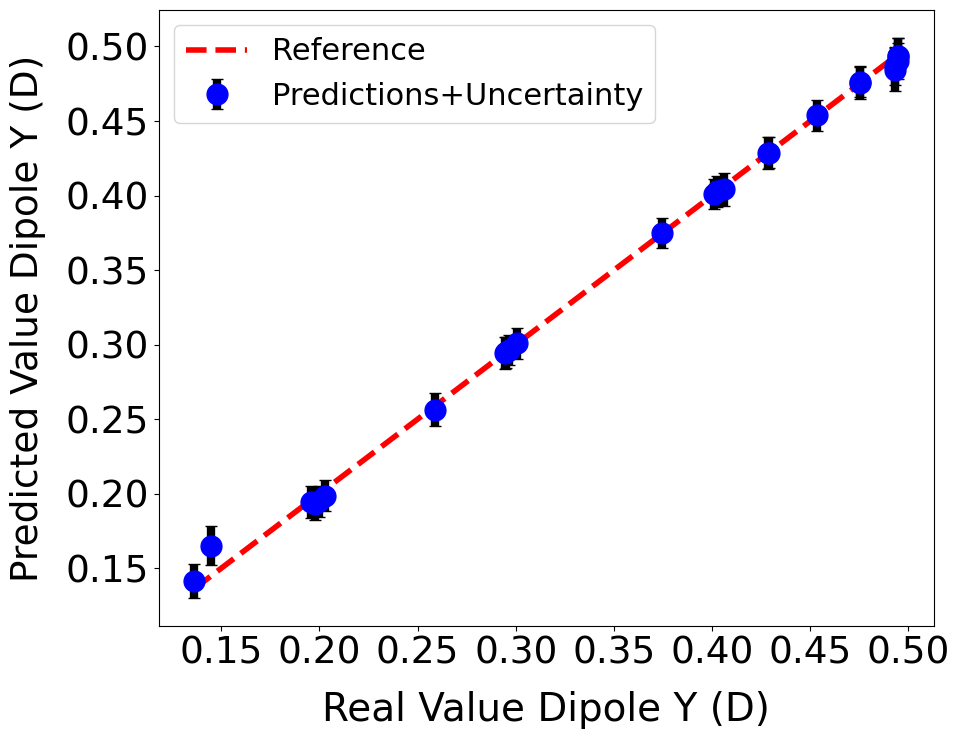

In [ ]:
std_6=var_6.sqrt().numpy()
sigma_y=scaler_y_2.scale_[0]
std_6=std_6*sigma_y
plt.figure(figsize=(10, 8))
plt.errorbar(
    y_test_2.numpy(),               # Valores reales (x)
    preds_6.numpy(),              # Predicciones (y)
    yerr=std_6,                   # Error vertical (barra de incertidumbre)
    fmt='o',                      # Marcador circular
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_2.numpy()), max(y_test_2.numpy())], [min(y_test_2.numpy()), max(y_test_2.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole Y (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole Y (D)',fontsize=27,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_locator(MultipleLocator(0.08))
#ax.yaxis.set_major_locator(MultipleLocator(0.08))
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
#plt.title('Energía por el RBF con lr=0.1')
plt.legend(fontsize=22)
plt.show()

MATERN KERNEL nu=1.5 RESULTS

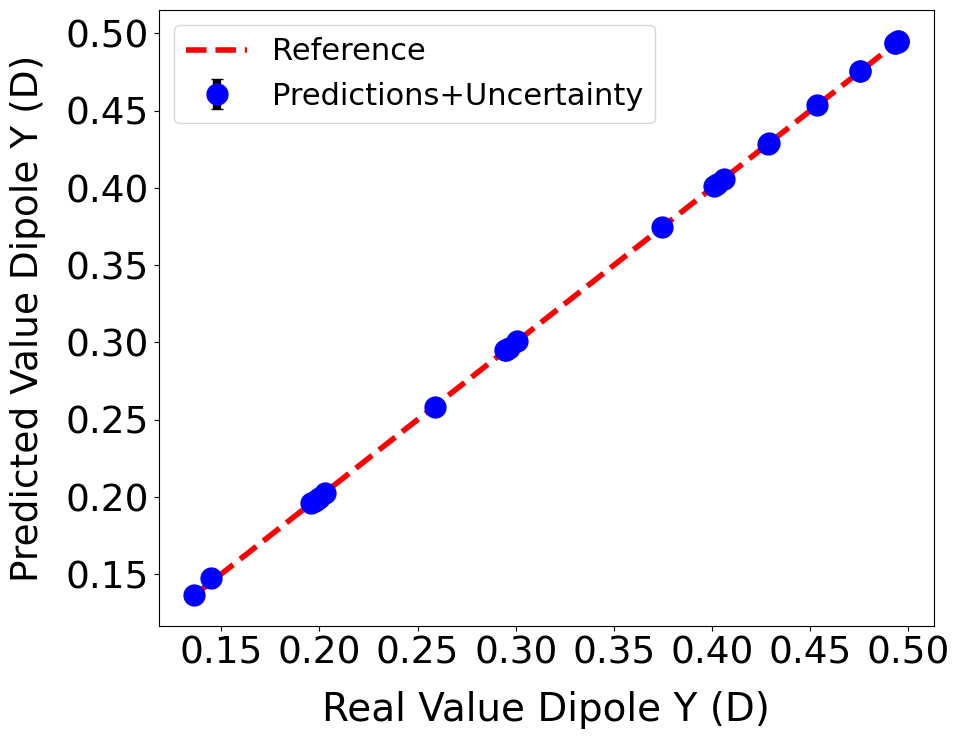

In [ ]:
std_7=var_7.sqrt().numpy()
sigma_y=scaler_y_2.scale_[0]
std_7=std_7*sigma_y
plt.figure(figsize=(10, 8))
plt.errorbar(
    y_test_2.numpy(),
    preds_7.numpy(),
    yerr=std_7,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_2.numpy()), max(y_test_2.numpy())], [min(y_test_2.numpy()), max(y_test_2.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole Y (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole Y (D)',fontsize=27,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_locator(MultipleLocator(0.08))
#ax.yaxis.set_major_locator(MultipleLocator(0.08))
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=22)
plt.show()

MATERN KERNEL nu=2.5 RESULTS

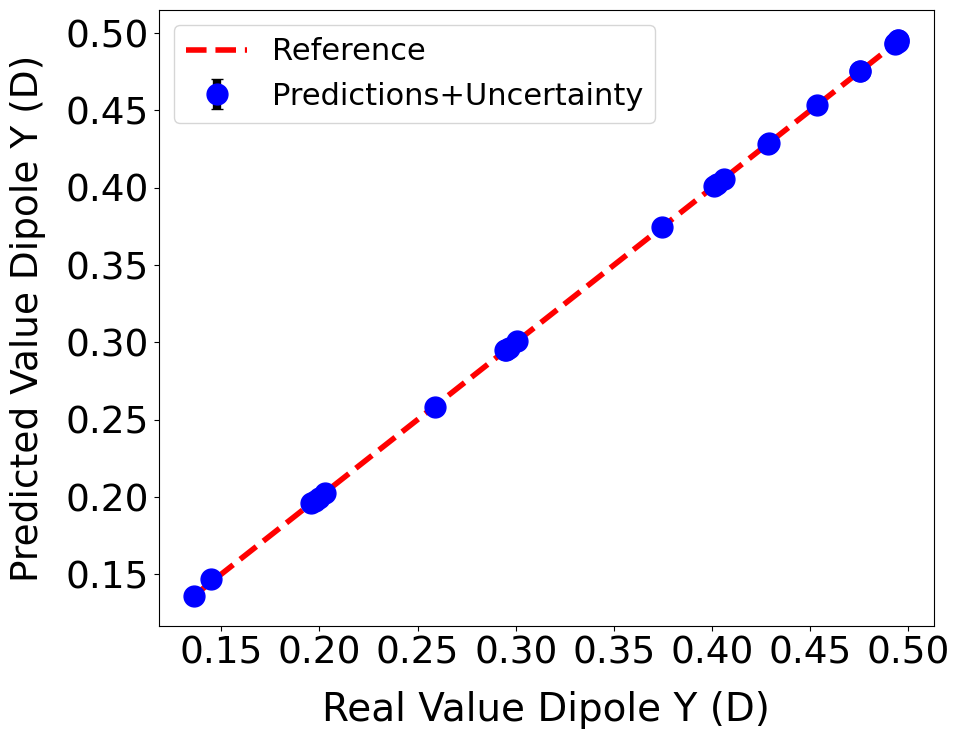

In [ ]:
std_8=var_8.sqrt().numpy()
sigma_y=scaler_y_2.scale_[0]
std_8=std_8*sigma_y
plt.figure(figsize=(10, 8))
plt.errorbar(
    y_test_2.numpy(),
    preds_8.numpy(),
    yerr=std_8,
    fmt='o',
    color='blue',
    ecolor='black',
    elinewidth=6,
    capsize=4,
    markersize=15,
    label='Predictions+Uncertainty',
)
plt.plot([min(y_test_2.numpy()), max(y_test_2.numpy())], [min(y_test_2.numpy()), max(y_test_2.numpy())], color='red', linestyle='--', label='Reference',linewidth=4)
plt.xlabel('Real Value Dipole Y (D)',fontsize=28,labelpad=14)
plt.ylabel('Predicted Value Dipole Y (D)',fontsize=27,labelpad=14)
ax=plt.gca()
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
#ax.xaxis.set_major_locator(MultipleLocator(0.08))
#ax.yaxis.set_major_locator(MultipleLocator(0.08))
plt.xticks(fontsize=27)
plt.yticks(fontsize=27)
plt.legend(fontsize=22)
plt.show()

NLML EVOLUTION DURING TRAINING

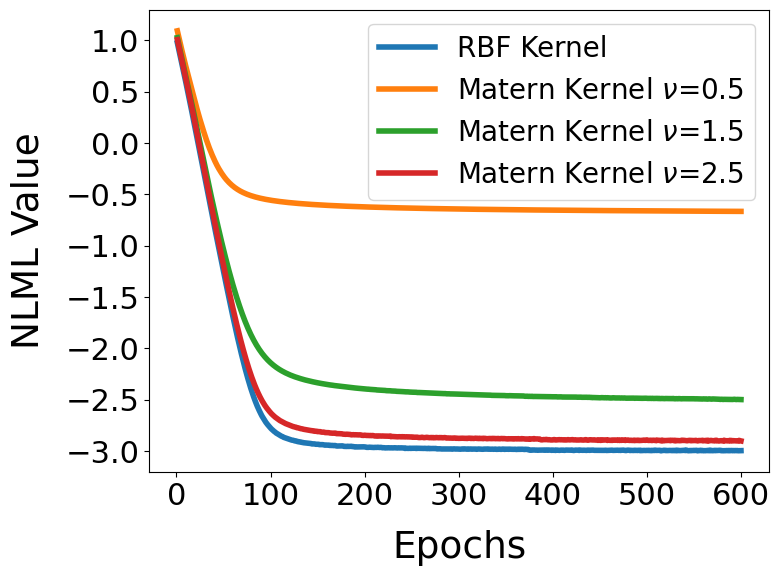

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(epocas_1,perdida_1,label='RBF Kernel',linewidth=4)
plt.plot(epocas_2,perdida_2,label=r'Matern Kernel $\nu$=0.5',linewidth=4)
plt.plot(epocas_3,perdida_3,label=r'Matern Kernel $\nu$=1.5',linewidth=4)
plt.plot(epocas_4,perdida_4,label=r'Matern Kernel $\nu$=2.5',linewidth=4)
plt.xlabel('Epochs',fontsize=27,labelpad=14)
plt.ylabel('NLML Value',fontsize=27,labelpad=14)
plt.xticks(fontsize=22)
plt.yticks(fontsize=22)
plt.legend(fontsize=20)
plt.show()

In [ ]:
mse_1=torch.nn.functional.mse_loss(preds_5,y_test_2)
mse_2=torch.nn.functional.mse_loss(preds_6,y_test_2)
mse_3=torch.nn.functional.mse_loss(preds_7,y_test_2)
mse_4=torch.nn.functional.mse_loss(preds_8,y_test_2)

r_1=r2_score(y_test_2.numpy(),preds_5.numpy())
r_2=r2_score(y_test_2.numpy(),preds_6.numpy())
r_3=r2_score(y_test_2.numpy(),preds_7.numpy())
r_4=r2_score(y_test_2.numpy(),preds_8.numpy())

print(f"MSE del modelo Lineal: {mse_1.item()}")
print(f"MSE del modelo Matern: {mse_2.item()}")
print(f"MSE del modelo Matern 2: {mse_3.item()}")
print(f"MSE del modelo Matern 3: {mse_4.item()}")

print(f"R2 del modelo Lineal: {r_1}")
print(f"R2 del modelo Matern: {r_2}")
print(f"R2 del modelo Matern 2: {r_3}")
print(f"R2 del modelo Matern 3: {r_4}")

MSE del modelo Lineal: 4.1953978779929457e-07
MSE del modelo Matern: 2.628072616062127e-05
MSE del modelo Matern 2: 4.920572109767818e-07
MSE del modelo Matern 3: 3.068803664518782e-07
R2 del modelo Lineal: 0.999971330165863
R2 del modelo Matern: 0.9982033967971802
R2 del modelo Matern 2: 0.9999663829803467
R2 del modelo Matern 3: 0.9999790191650391


EVOLUTION OF THE R² COEFFICIENT WITH THE SIZE OF THE TRAINING DATASET FOR THE X-AXIS DIPOLE MOMENT

In [ ]:
tamaño_dataset=[0.06,0.075,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

#Defino el learning rate y el número de épocas de entrenamiento
num_epocas=600
lr=0.1

#Ahora inicio listas para guardar los datos
r_Full_RBF=[]
r_Full_Matern_1=[]
r_Full_Matern_2=[]
r_Full_Matern_3=[]

for tamaño in tamaño_dataset:
  x_data=torch.tensor(features,dtype=torch.float32)
  y_data=torch.tensor(labels.values,dtype=torch.float32)
  Dipole_train,Dipole_test,y_train,y_test=train_test_split(x_data,y_data,train_size=tamaño,random_state=42)
  y_train_1=y_train[:,0]
  y_test_1=y_test[:,0]

  scaler=StandardScaler()
  Dipole_train_scaled=scaler.fit_transform(Dipole_train)
  Dipole_test_scaled=scaler.transform(Dipole_test)
  Dipole_train=torch.tensor(Dipole_train_scaled,dtype=torch.float32)
  Dipole_test=torch.tensor(Dipole_test_scaled,dtype=torch.float32)

  #Escalado en y
  scaler_y=StandardScaler()
  y_train_1=y_train_1.reshape(-1,1)
  y_test_1=y_test_1.reshape(-1,1)
  y_train_1_scaled=scaler_y.fit_transform(y_train_1).reshape(-1)
  y_test_1_scaled=scaler_y.transform(y_test_1).reshape(-1)
  y_train_1=torch.tensor(y_train_1_scaled,dtype=torch.float32)
  y_test_1=torch.tensor(y_test_1_scaled,dtype=torch.float32)

  #Genero el primero modelo entreno y calculo el R2
  likelihood_1=gpytorch.likelihoods.GaussianLikelihood()
  model_1=GPModel(Dipole_train,y_train_1,likelihood_1)
  epocas_1,likelihood_1,perdida_1,model_1=train_model(model_1,likelihood_1,num_epocas,lr,Dipole_train,y_train_1)
  preds_1,_=evaluate_model(model_1,likelihood_1,Dipole_test)
  r_Full_RBF.append(r2_score(y_test_1,preds_1))

  #Genero el segundo modelo entreno y calculo el R2
  likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
  model_2=GPTmodel_2(Dipole_train,y_train_1,likelihood_2,0.5)
  epocas_2,likelihood_2,perdida_2,model_2=train_model(model_2,likelihood_2,num_epocas,lr,Dipole_train,y_train_1)
  preds_2,_=evaluate_model(model_2,likelihood_2,Dipole_test)
  r_Full_Matern_1.append(r2_score(y_test_1,preds_2))

  #Genero el tercer modelo entreno y calculo el R2
  likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
  model_3=GPTmodel_2(Dipole_train,y_train_1,likelihood_3,1.5)
  epocas_3,likelihood_3,perdida_3,model_3=train_model(model_3,likelihood_3,num_epocas,lr,Dipole_train,y_train_1)
  preds_3,_=evaluate_model(model_3,likelihood_3,Dipole_test)
  r_Full_Matern_2.append(r2_score(y_test_1,preds_3))

  #Genero el cuarto modelo entreno y calculo el R2
  likelihood_4=gpytorch.likelihoods.GaussianLikelihood()
  model_4=GPTmodel_2(Dipole_train,y_train_1,likelihood_4,2.5)
  epocas_4,likelihood_4,perdida_4,model_4=train_model(model_4,likelihood_4,num_epocas,lr,Dipole_train,y_train_1)
  preds_4,_=evaluate_model(model_4,likelihood_4,Dipole_test)
  r_Full_Matern_3.append(r2_score(y_test_1,preds_4))

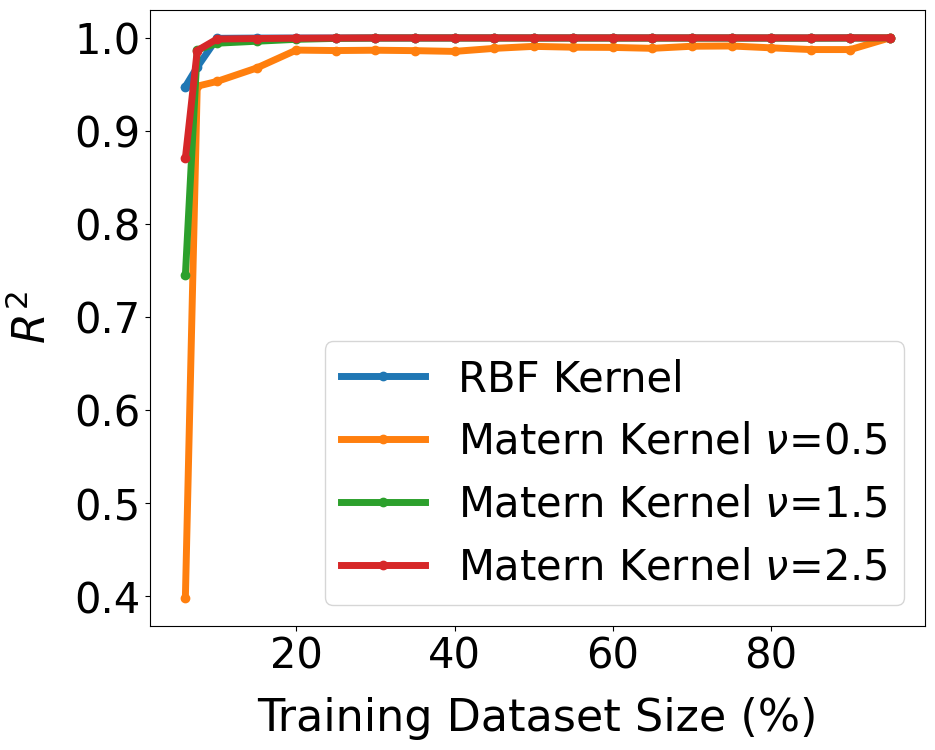

In [ ]:
tamaño_dataset=[6,7.5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.figure(figsize=(10, 8))
plt.plot(tamaño_dataset,r_Full_RBF,marker='o',label='RBF Kernel',linewidth=5)
plt.plot(tamaño_dataset,r_Full_Matern_1,marker='o',label=r'Matern Kernel $\nu$=0.5',linewidth=5)
plt.plot(tamaño_dataset,r_Full_Matern_2,marker='o',label=r'Matern Kernel $\nu$=1.5',linewidth=5)
plt.plot(tamaño_dataset,r_Full_Matern_3,marker='o',label=r'Matern Kernel $\nu$=2.5',linewidth=5)
plt.xlabel('Training Dataset Size (%)',fontsize=32,labelpad=14)
plt.ylabel(r'$R^{2}$',fontsize=32,labelpad=14)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
plt.show()

EVOLUTION OF THE R² COEFFICIENT WITH THE SIZE OF THE TRAINING DATASET FOR THE Y-AXIS DIPOLE MOMENT

In [ ]:
tamaño_dataset=[0.06,0.075,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]

#Defino el learning rate y el número de épocas de entrenamiento
num_epocas=600
lr=0.1

#Ahora inicio listas para guardar los datos
r_Full_RBF=[]
r_Full_Matern_1=[]
r_Full_Matern_2=[]
r_Full_Matern_3=[]

for tamaño in tamaño_dataset:
  x_data=torch.tensor(features,dtype=torch.float32)
  y_data=torch.tensor(labels.values,dtype=torch.float32)
  Dipole_train,Dipole_test,y_train,y_test=train_test_split(x_data,y_data,train_size=tamaño,random_state=42)
  y_train_1=y_train[:,1]
  y_test_1=y_test[:,1]

  scaler=StandardScaler()
  Dipole_train_scaled=scaler.fit_transform(Dipole_train)
  Dipole_test_scaled=scaler.transform(Dipole_test)
  Dipole_train=torch.tensor(Dipole_train_scaled,dtype=torch.float32)
  Dipole_test=torch.tensor(Dipole_test_scaled,dtype=torch.float32)

  #Escalado en y
  scaler_y=StandardScaler()
  y_train_1=y_train_1.reshape(-1,1)
  y_test_1=y_test_1.reshape(-1,1)
  y_train_1_scaled=scaler_y.fit_transform(y_train_1).reshape(-1)
  y_test_1_scaled=scaler_y.transform(y_test_1).reshape(-1)
  y_train_1=torch.tensor(y_train_1_scaled,dtype=torch.float32)
  y_test_1=torch.tensor(y_test_1_scaled,dtype=torch.float32)

  #Genero el primero modelo entreno y calculo el R2
  likelihood_1=gpytorch.likelihoods.GaussianLikelihood()
  model_1=GPModel(Dipole_train,y_train_1,likelihood_1)
  epocas_1,likelihood_1,perdida_1,model_1=train_model(model_1,likelihood_1,num_epocas,lr,Dipole_train,y_train_1)
  preds_1,_=evaluate_model(model_1,likelihood_1,Dipole_test)
  r_Full_RBF.append(r2_score(y_test_1,preds_1))

  #Genero el segundo modelo entreno y calculo el R2
  likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
  model_2=GPTmodel_2(Dipole_train,y_train_1,likelihood_2,0.5)
  epocas_2,likelihood_2,perdida_2,model_2=train_model(model_2,likelihood_2,num_epocas,lr,Dipole_train,y_train_1)
  preds_2,_=evaluate_model(model_2,likelihood_2,Dipole_test)
  r_Full_Matern_1.append(r2_score(y_test_1,preds_2))

  #Genero el tercer modelo entreno y calculo el R2
  likelihood_3=gpytorch.likelihoods.GaussianLikelihood()
  model_3=GPTmodel_2(Dipole_train,y_train_1,likelihood_3,1.5)
  epocas_3,likelihood_3,perdida_3,model_3=train_model(model_3,likelihood_3,num_epocas,lr,Dipole_train,y_train_1)
  preds_3,_=evaluate_model(model_3,likelihood_3,Dipole_test)
  r_Full_Matern_2.append(r2_score(y_test_1,preds_3))

  #Genero el cuarto modelo entreno y calculo el R2
  likelihood_4=gpytorch.likelihoods.GaussianLikelihood()
  model_4=GPTmodel_2(Dipole_train,y_train_1,likelihood_4,2.5)
  epocas_4,likelihood_4,perdida_4,model_4=train_model(model_4,likelihood_4,num_epocas,lr,Dipole_train,y_train_1)
  preds_4,_=evaluate_model(model_4,likelihood_4,Dipole_test)
  r_Full_Matern_3.append(r2_score(y_test_1,preds_4))

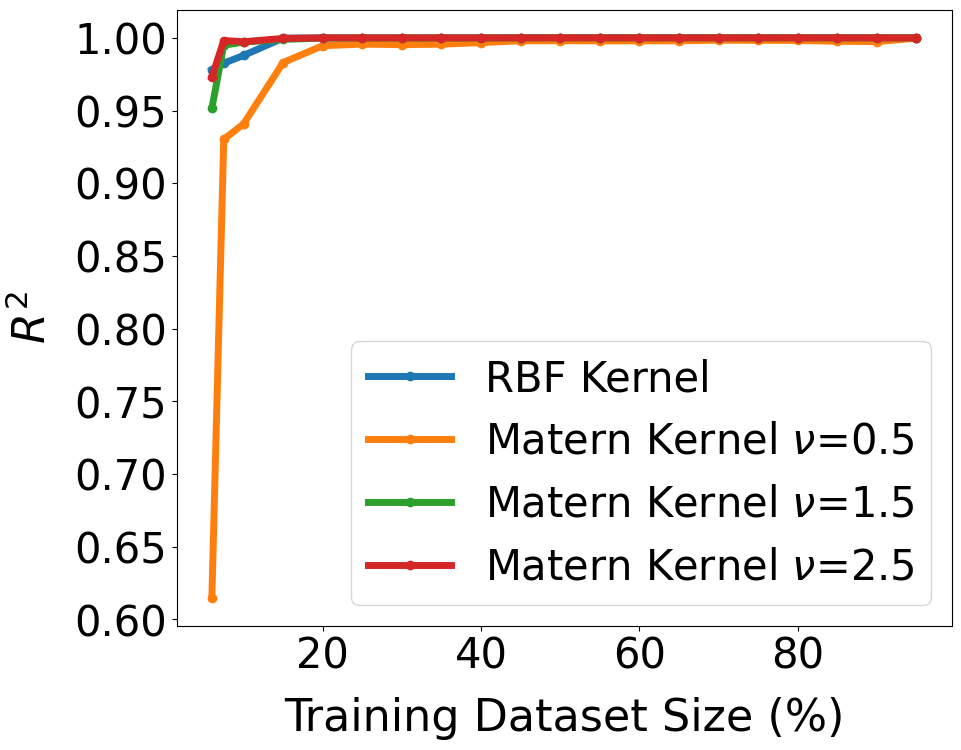

In [ ]:
tamaño_dataset=[6,7.5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.figure(figsize=(10, 8))
plt.plot(tamaño_dataset,r_Full_RBF,marker='o',label='RBF Kernel',linewidth=5)
plt.plot(tamaño_dataset,r_Full_Matern_1,marker='o',label=r'Matern Kernel $\nu$=0.5',linewidth=5)
plt.plot(tamaño_dataset,r_Full_Matern_2,marker='o',label=r'Matern Kernel $\nu$=1.5',linewidth=5)
plt.plot(tamaño_dataset,r_Full_Matern_3,marker='o',label=r'Matern Kernel $\nu$=2.5',linewidth=5)
plt.xlabel('Training Dataset Size (%)',fontsize=32,labelpad=14)
plt.ylabel(r'$R^{2}$',fontsize=32,labelpad=14)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=30)
plt.show()

## OCM DATASET

DATASET ANALYSIS

In [ ]:
#Monto el contenido del drive
drive.mount('/content/drive')

#Defino el camino a el archivo que quiero importar
path="/content/drive/MyDrive/Colab Notebooks/TFM/Bayesian_TFM/OCM_dataset.xlsx"

dataset=pd.read_excel(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


CATIONS INVOLVED

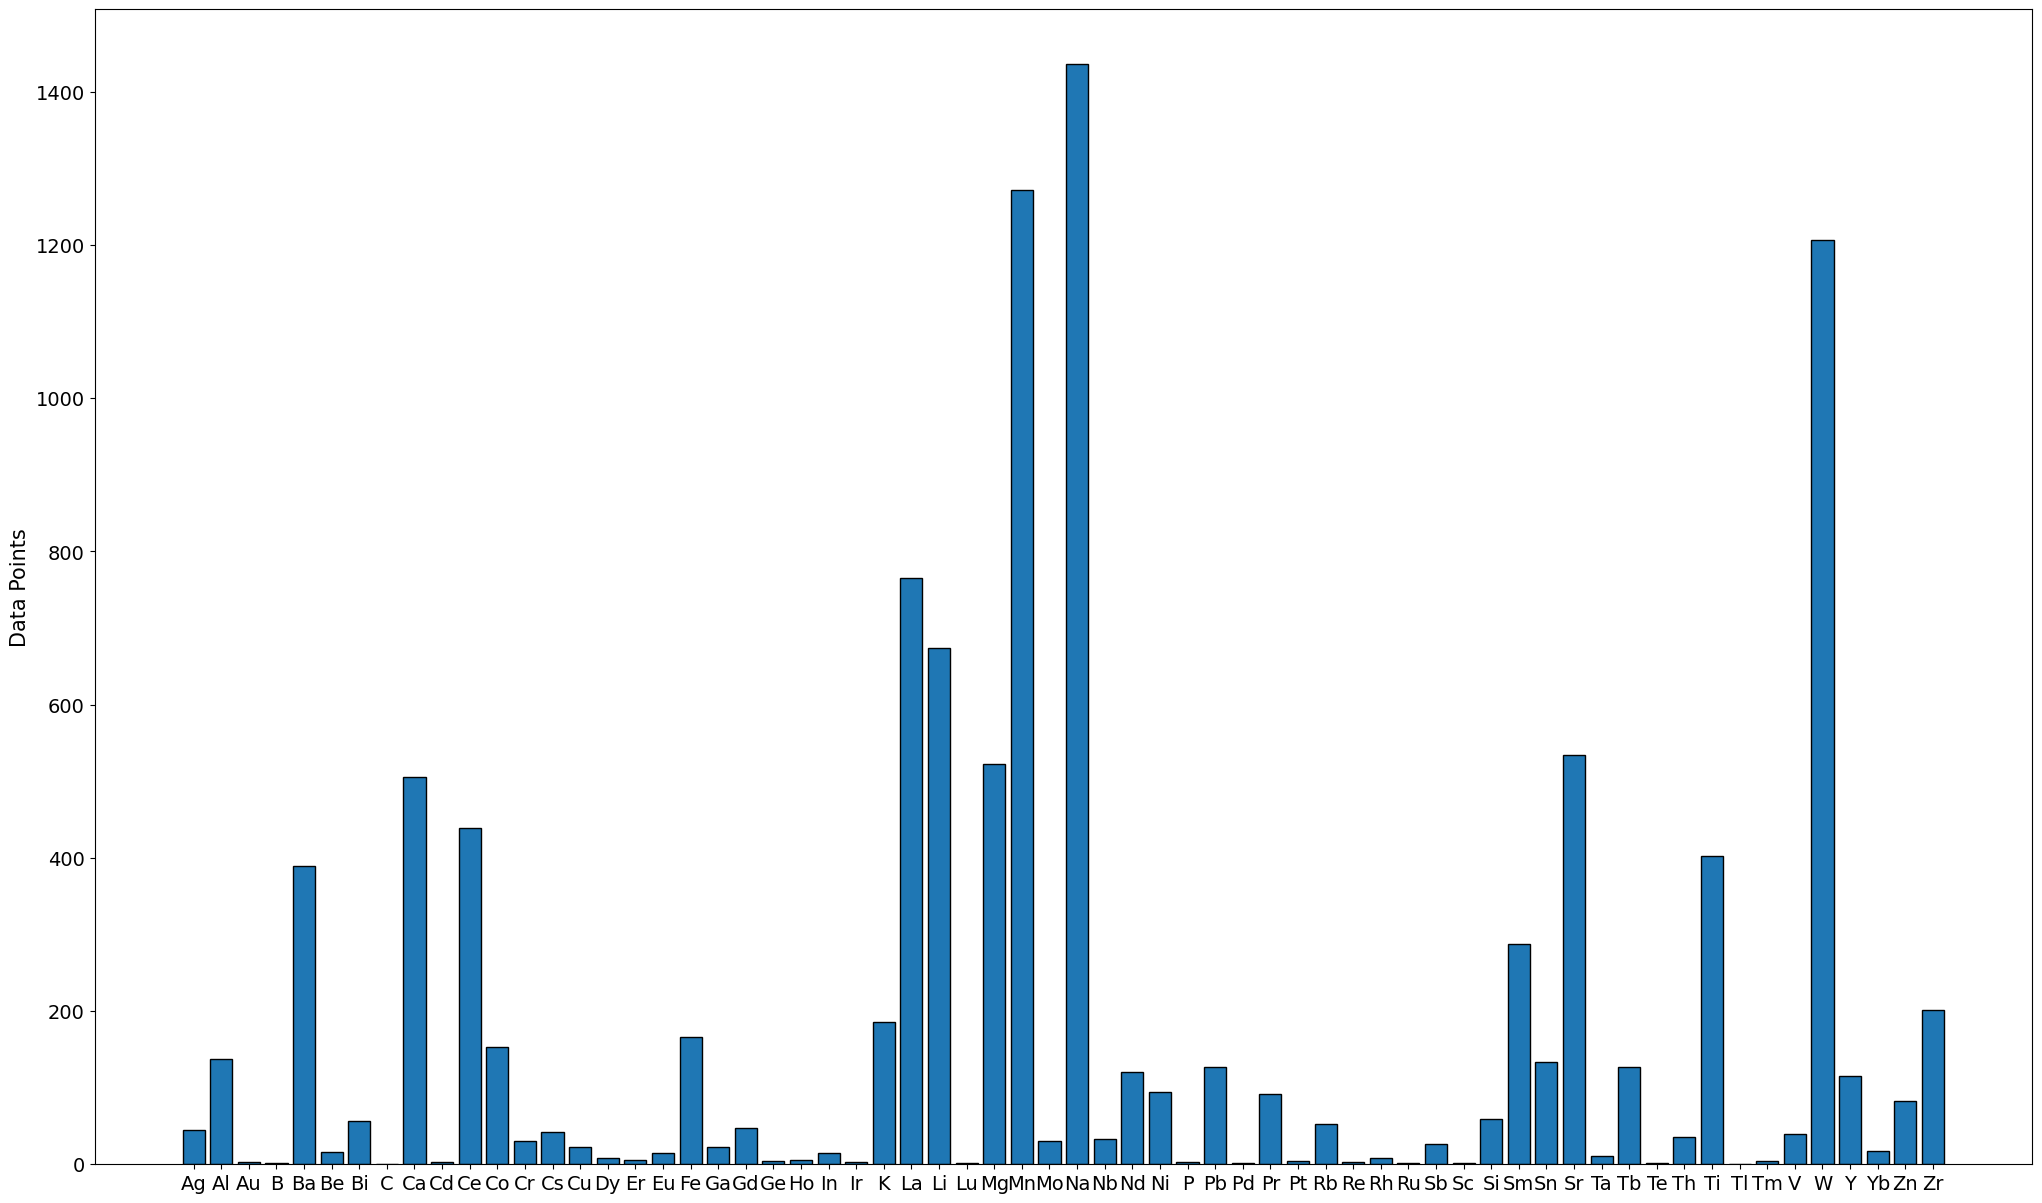

In [ ]:
#Datos para los cationes
cation_1_counts=dataset['Cation 1'].value_counts()
cation_2_counts=dataset['Cation 2'].value_counts()
cation_3_counts=dataset['Cation 3'].value_counts()
cation_4_counts=dataset['Cation 4'].value_counts()
cation_5_counts=dataset['Cation 5'].value_counts()
cation_6_counts=dataset['Cation 6'].value_counts()

#Me genero el datset de los cationes para poder trabajar con el
total_counts = (cation_1_counts.add(cation_2_counts, fill_value=0)
                .add(cation_3_counts, fill_value=0)
                .add(cation_4_counts, fill_value=0)
                .add(cation_5_counts, fill_value=0)
                .add(cation_6_counts, fill_value=0))

#Ahora voy a contar todos los valores que se repiten los cationes
total_counts_df=total_counts.to_frame(name="Total Count")

#Hago ahora un histograma dónde mostamos esto
plt.figure(figsize=(25,15))
plt.bar(total_counts_df.index,total_counts_df['Total Count'],edgecolor='black')
plt.ylabel('Data Points',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

ANION TYPE

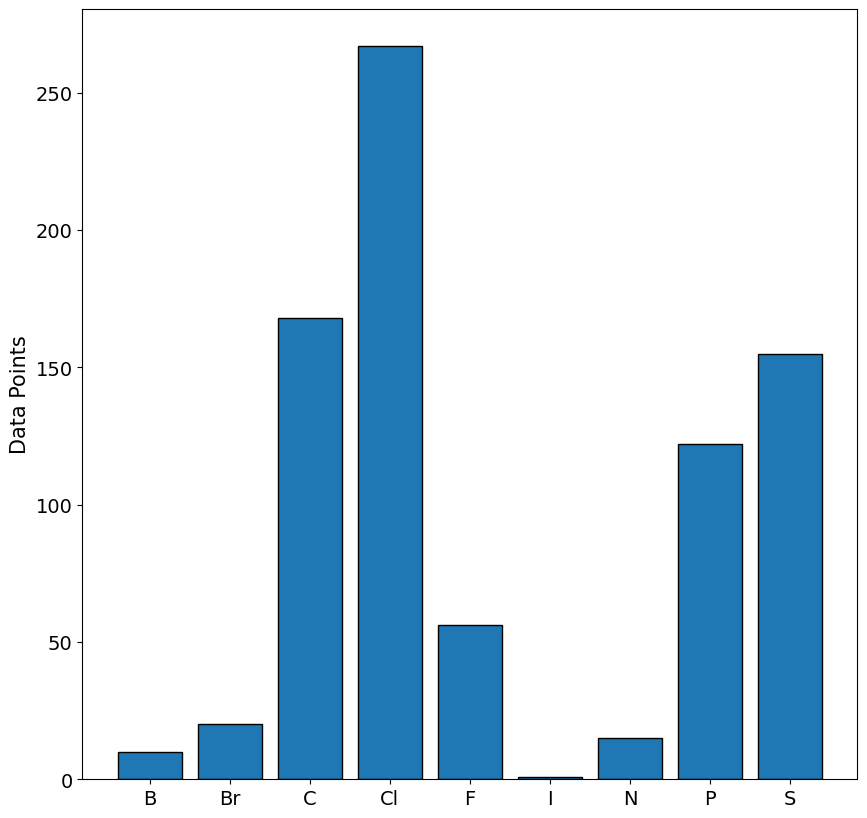

In [ ]:
#Extraigo primero los aniones
anion_1_counts=dataset['Anion 1'].value_counts()
anion_2_counts=dataset['Anion 2'].value_counts()

#Genero una dataset con los aniones
total_counts_anion = (anion_1_counts.add(anion_2_counts, fill_value=0))

#Cuento los valores totales
total_counts_anion_df=total_counts_anion.to_frame(name="Total Count")

#Genero el histograma con los valores
plt.figure(figsize=(10,10))
plt.bar(total_counts_anion_df.index,total_counts_anion_df['Total Count'],edgecolor='black')
plt.ylabel('Data Points',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

SUPPORTS

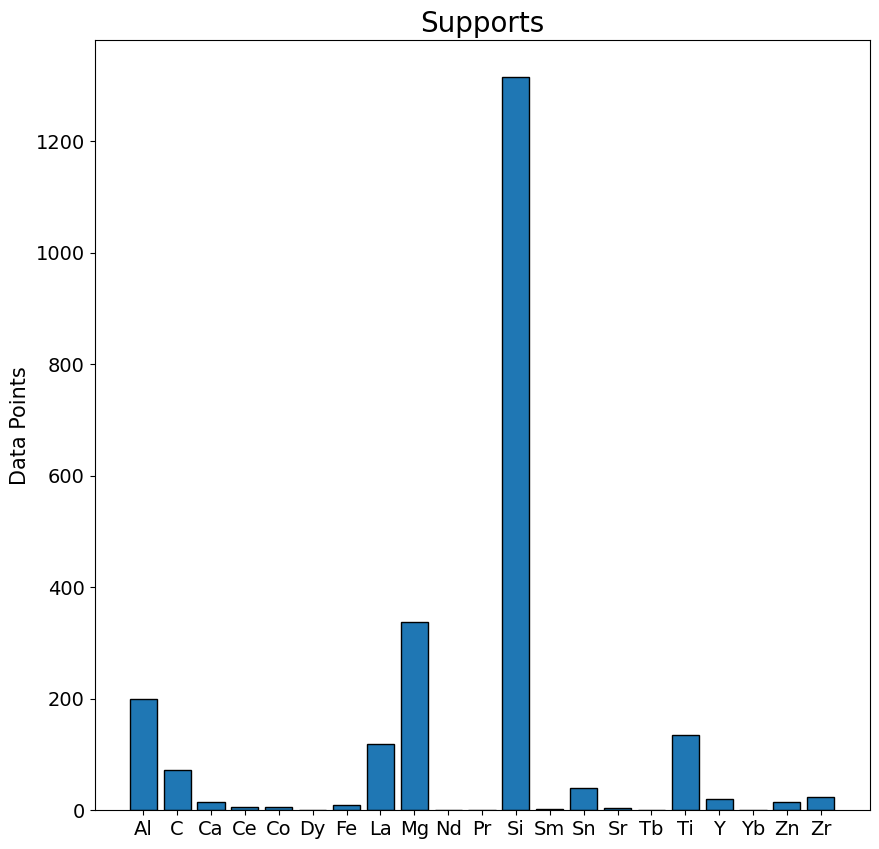

In [ ]:
#Extraigo primero los valores
support_1_counts=dataset['Support 1'].value_counts()
support_2_counts=dataset['Support 2'].value_counts()
support_3_counts=dataset['Support 3'].value_counts()

#Genero el dataset correspondiente
total_counts_support = (support_1_counts.add(support_2_counts, fill_value=0)
                .add(support_3_counts, fill_value=0))


#Cuento los valores totales
total_counts_support_df=total_counts_support.to_frame(name="Total Count")

#Genero el histograma correspondiente
plt.figure(figsize=(10,10))
plt.bar(total_counts_support_df.index,total_counts_support_df['Total Count'],edgecolor='black')
plt.ylabel('Data Points',fontsize=15)
plt.title('Supports',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

REACTION TEMPERATURE

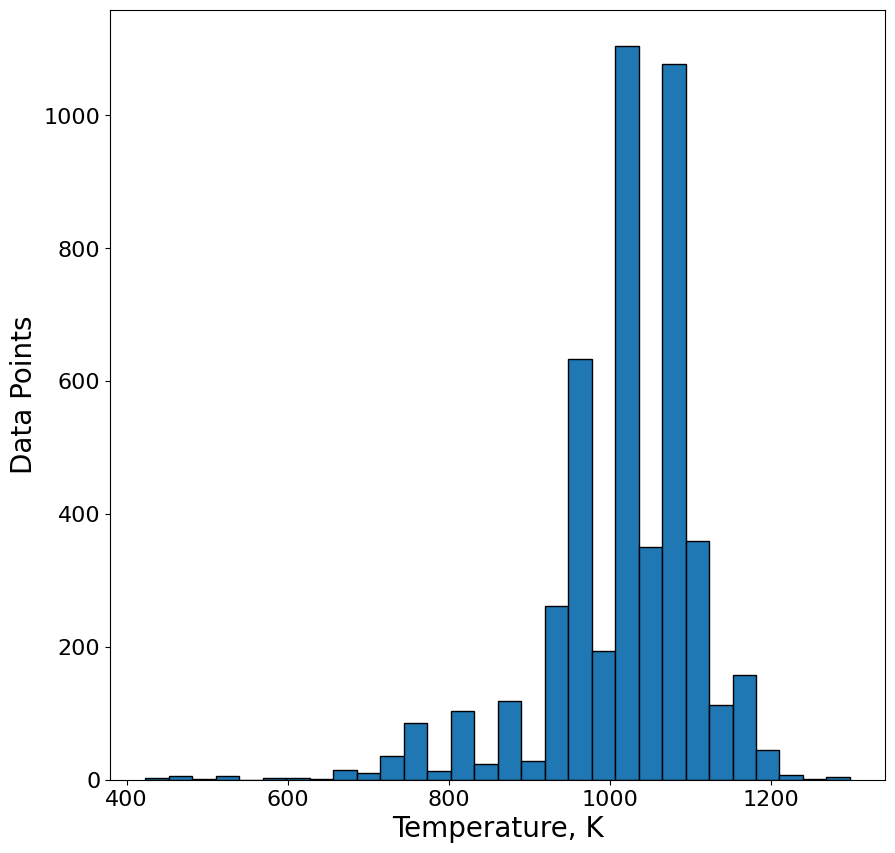

In [ ]:
#Extraigo primero los valores
temperature=dataset['Temperature, K'].value_counts()

#Genero el histograma correspondiente
plt.figure(figsize=(10,10))
plt.hist(dataset['Temperature, K'],bins=30,edgecolor='black')  # Ajusta `bins` según nivel de agrupamiento
plt.ylabel('Data Points',fontsize=20)
plt.xlabel('Temperature, K',fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

PREPARATION METHOD

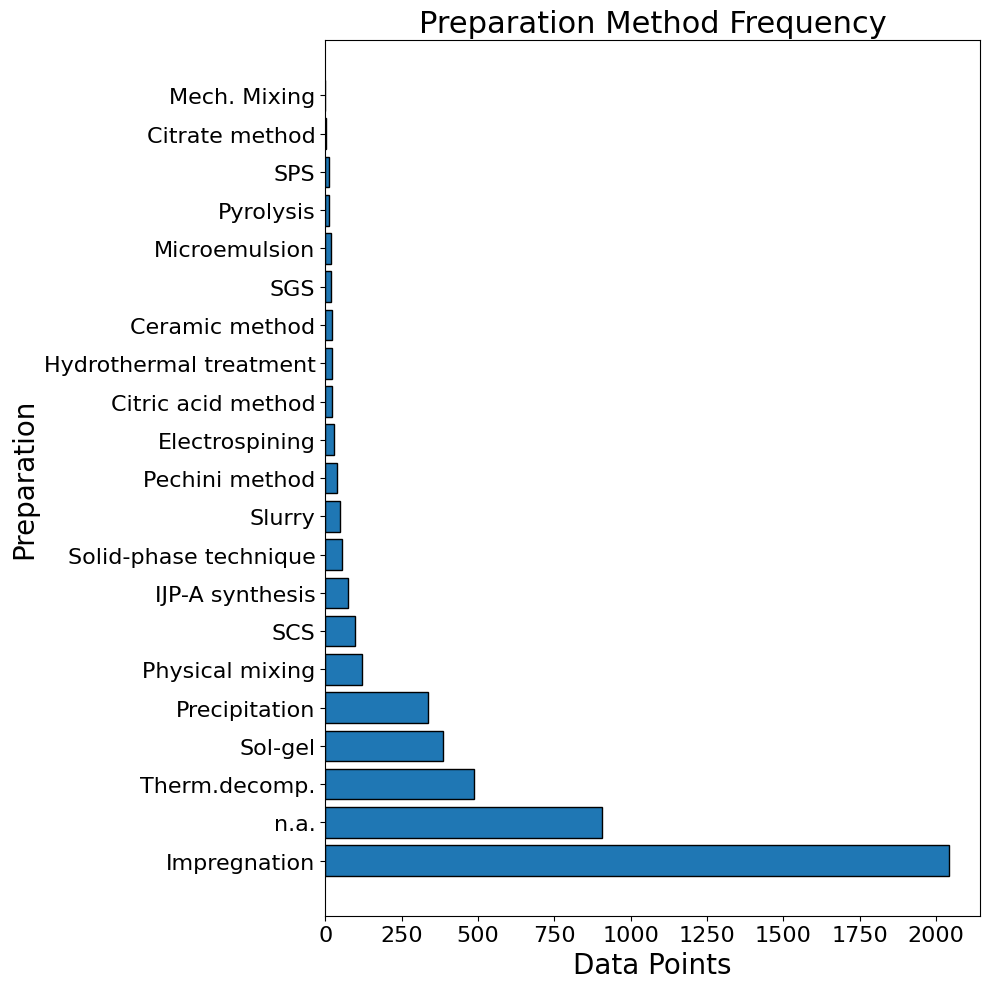

In [ ]:
preparation_counts = dataset['Preparation'].value_counts()

# Graficar barras horizontales
plt.figure(figsize=(10,10))
plt.barh(preparation_counts.index, preparation_counts.values, edgecolor='black')
plt.xlabel('Data Points', fontsize=20)
plt.ylabel('Preparation', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Preparation Method Frequency', fontsize=22)
plt.tight_layout()
plt.show()

YIELD DATA

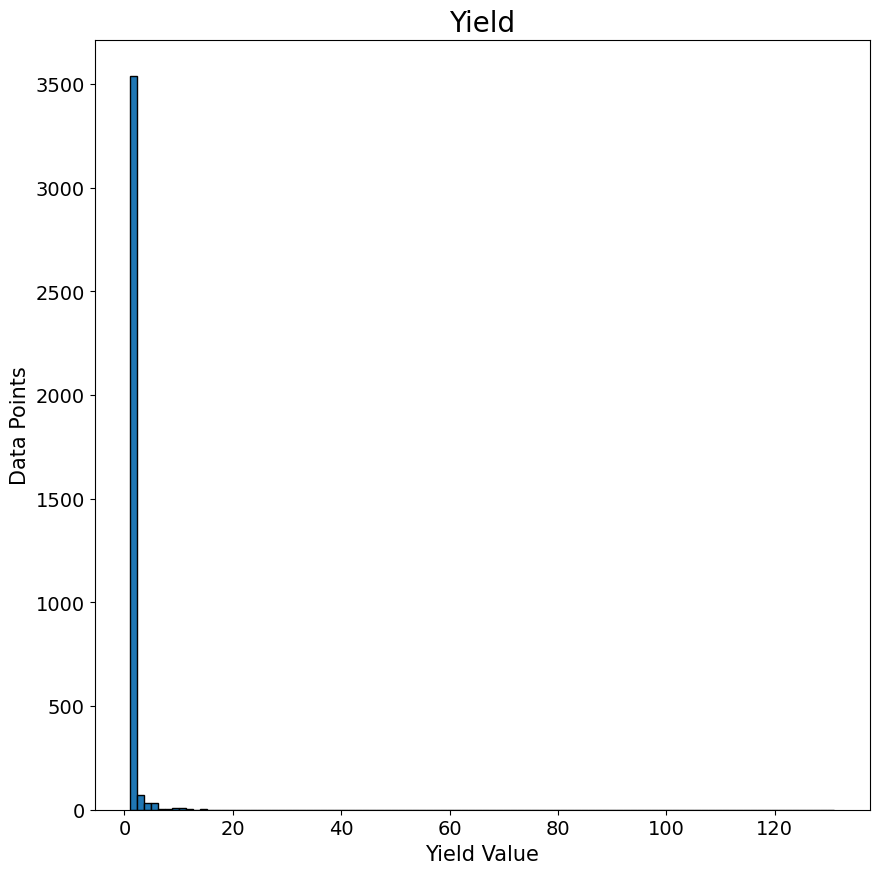

In [ ]:
#Extraigo los valores
yield_counts=dataset['Y(C2), %'].value_counts()

#Realizo un histograma con los datos
plt.figure(figsize=(10,10))
plt.hist(yield_counts,bins=100,edgecolor='black')
plt.ylabel('Data Points',fontsize=15)
plt.xlabel('Yield Value',fontsize=15)
plt.title('Yield',fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

RANDOM INDUCING POINTS VS K-MEANS INIZIALIZATION

In [ ]:
file_path='C:/Users/farag/Documents/Carrera/Master UAM/TFM/DATOS_OCM/OCM_dataset.xlsx'
df=pd.read_excel(file_path)

#Eliminamos filas con valores faltantes en la columna objetivo
df=df.dropna(subset=['Y(C2), %'])

#Separamos variables independientes y dependientes
X=df.drop(columns=['Y(C2), %'])

#Eliminamos la columna 'Nr of publication' si está presente
if 'Nr of publication' in X.columns:
    X = X.drop(columns=['Nr of publication'])

#Guardamos columnas a eliminar
columnas_eliminadas=X.columns[-6:]
x_data=X.iloc[:, :-6]

Yield_data=df['Y(C2), %']

#Separamos columnas categóricas y numéricas
categorical_cols=x_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols=x_data.select_dtypes(exclude=['object']).columns.tolist()
category_lists = []
for col in categorical_cols:
    col_data = x_data[col].fillna('missing')
    category_lists.append(col_data.unique().tolist())

#Verificamos
print("Columnas eliminadas:",list(columnas_eliminadas))
print("Columnas restantes:",list(x_data.columns))

def definir_transformadores(numerical_cols, categorical_cols,category_lists):
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, keep_empty_features=True)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(categories=category_lists,handle_unknown='ignore', sparse_output=False))
    ])

    return ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

class SparseGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution=CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy=VariationalStrategy(self,inducing_points,variational_distribution,learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module=ConstantMean()
        self.covar_module=ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5,ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x=self.mean_module(x)
        covar_x=self.covar_module(x)
        return MultivariateNormal(mean_x,covar_x)

def train_model_Sparse(model,likelihood,num_epochs,lr,x_train,y_train):
  #Primero selecciono todos los parámetros no duplicados del modelo
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params+likelihood_params))
  optimizer=torch.optim.Adam(all_params, lr=lr)
  mll=gpytorch.mlls.VariationalELBO(likelihood,model,num_data=y_train.size(0))

  #Defino ahora variables dónde guardar las épocas y el loss
  epocas=[]
  perdida=[]

  #Inicializo la función de entrenamiento
  model.train()
  likelihood.train()

  #Entrenando el modelo
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    #Calculamos la pérdida usando la función forward en lugar de marginal
    loss=-mll(output,y_train)
    loss.backward()  # Retropropagamos los gradientes
    optimizer.step()  # Actualizamos los parámetros del modelo
    #Guardamos las variables de pérdida y época
    perdida.append(-loss.item())
    epocas.append(i+1)

  return epocas,likelihood,perdida,model

#Defino una función que me realice la evaluación del modelo
def evaluate_model(model,likelihood,x_test):
  model.eval()
  likelihood.eval()
  with torch.no_grad():
    test_preds=likelihood(model(x_test))
    preds=test_preds.mean
  return preds

#Defino una función para lo del k-means
from sklearn.cluster import KMeans

def kmeans(X_train, num_inducing):
    random_state=0
    #Aplicar KMeans
    X_np=X_train.detach().cpu().numpy()
    kmeans=KMeans(n_clusters=num_inducing,n_init=10,init="k-means++",random_state=random_state)
    kmeans.fit(X_np)

    # Obtener inducing points (igual que antes)
    inducing_points = torch.tensor(kmeans.cluster_centers_,dtype=X_train.dtype,device=X_train.device)
    return inducing_points

#Vamos a definir el tamaño del dataset que vamos a usar para la prueba
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans
tamaño_dataset=0.5

#Defino el learning rate y el número de épocas de entrenamiento
num_epocas=900
lr=0.01

#Ahora inicio listas para guardar los datos
r_Sparse=[]
r_Sparse_2=[]

#Añado listas para guardar los tiempos
tiempo_Sparse=[]
tiempo_Sparse_2=[]

#Defino aquí el porcentaje de inducing points que vamos a usar
inducing_pon=[0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22]

#Ahora realizamos un bucle que me recorra todos los valores de inducing points
for i_p in inducing_pon:
  #Defino el tamaño de los test
  tamaño_test=1-tamaño_dataset
  #Divido el dataset original en train y test
  x_train,x_test,Yield_train,Yield_test=train_test_split(x_data,Yield_data,test_size=tamaño_test,random_state=42)

  #Aplico ahora la transformación de datos
  preprocessor=definir_transformadores(numerical_cols,categorical_cols,category_lists)
  #Transformamos los puntos X
  x_train=preprocessor.fit_transform(x_train)
  x_test=preprocessor.transform(x_test)

  #Transformamos los datos del eje Y
  scaler_y=StandardScaler()
  Yield_train_scaled=scaler_y.fit_transform(Yield_train.values.reshape(-1,1))
  Yield_test_scaled=scaler_y.transform(Yield_test.values.reshape(-1,1))
  Yield_train=Yield_train_scaled.ravel()
  Yield_test=Yield_test_scaled.ravel()

  #Paso a forma tensorial
  x_train=torch.tensor(x_train,dtype=torch.float32)
  x_test=torch.tensor(x_test,dtype=torch.float32)
  Yield_train=torch.tensor(Yield_train,dtype=torch.float32)
  Yield_test=torch.tensor(Yield_test,dtype=torch.float32)

  #Primero hago el método aleatorio
  porcentaje_rep=i_p
  numero_datos_train=x_train.size(0)
  numero_datos_rep=int(numero_datos_train*porcentaje_rep)
  torch.manual_seed(46)
  representative_data=x_train[torch.randperm(x_train.size(0))[:numero_datos_rep]]

  #Genero el modelo lo entreno y calculo el R2
  likelihood=gpytorch.likelihoods.GaussianLikelihood()
  model=SparseGPModel(representative_data)
  time_start=time.time()
  epocas,likelihood,perdida,model=train_model_Sparse(model,likelihood,num_epocas,lr,x_train,Yield_train)
  preds=evaluate_model(model,likelihood,x_test)
  time_final=time.time()
  r_Sparse.append(r2_score(Yield_test,preds))
  tiempo_Sparse.append((time_final-time_start)/60)
  print(f"R2 Aleatorios:{r_Sparse}")
  print(f"Tiempo Aleatorios: {tiempo_Sparse}")

  #Ahora lo hago para el segundo método
  representative_data_2=kmeans(x_train,numero_datos_rep)
  likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
  model_2=SparseGPModel(representative_data_2)
  time_start_2=time.time()
  epocas_2,likelihood_2,perdida_2,model_2=train_model_Sparse(model_2,likelihood_2,num_epocas,lr,x_train,Yield_train)
  preds_2=evaluate_model(model_2,likelihood_2,x_test)
  time_final_2=time.time()
  r_Sparse_2.append(r2_score(Yield_test,preds_2))
  tiempo_Sparse_2.append((time_final_2-time_start_2)/60)
  print(f"R2 KMeans: {r_Sparse_2}")
  print(f"Tiempo KMeans: {tiempo_Sparse_2}")

PLOT OF R² EVOLUTION VS. THE NUMBER OF INDUCING POINTS

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(inducing_pon,r_Sparse,marker='o',label='Aleatorio')
plt.plot(inducing_pon,r_Sparse_2,marker='o',label='KMeans')
plt.xlabel('Percentage of Representative Data (%)',fontsize=16,labelpad=15)
plt.ylabel(r'$R^{2}$ Coefficient',fontsize=16,labelpad=15)
plt.legend()
plt.show()

EXECUTION TIME EVOLUTION WITH THE NUMBER OF INDUCING POINTS

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(inducing_pon,tiempo_Sparse,marker='o',label='Aleatorio')
plt.plot(inducing_pon,tiempo_Sparse_2,marker='o',label='KMeans')
plt.xlabel('Percentage of Representative Data (%)',fontsize=16,labelpad=15)
plt.ylabel('Execution Time (min)',fontsize=16,labelpad=15)
plt.legend()
plt.show()

RESULTS FOR K-MEANS INITIALIZATION

In [ ]:
file_path='C:/Users/farag/Documents/Carrera/Master UAM/TFM/DATOS_OCM/OCM_dataset.xlsx'
df=pd.read_excel(file_path)

#Eliminamos filas con valores faltantes en la columna objetivo
df=df.dropna(subset=['Y(C2), %'])

#Separamos variables independientes y dependientes
X=df.drop(columns=['Y(C2), %'])

#Eliminamos la columna 'Nr of publication' si está presente
if 'Nr of publication' in X.columns:
    X = X.drop(columns=['Nr of publication'])

#Guardamos columnas a eliminar
columnas_eliminadas=X.columns[-6:]
x_data=X.iloc[:,:-6]

Yield_data=df['Y(C2), %']

#Separamos columnas categóricas y numéricas
categorical_cols=x_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols=x_data.select_dtypes(exclude=['object']).columns.tolist()
category_lists=[]
for col in categorical_cols:
    col_data = x_data[col].fillna('missing')
    category_lists.append(col_data.unique().tolist())

#Verificamos
print("Columnas eliminadas:",list(columnas_eliminadas))
print("Columnas restantes:",list(x_data.columns))

def definir_transformadores(numerical_cols, categorical_cols,category_lists):
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant',fill_value=0,keep_empty_features=True)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(categories=category_lists,handle_unknown='ignore', sparse_output=False))
    ])

    return ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])

class SparseGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution=CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy=VariationalStrategy(self,inducing_points,variational_distribution,learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module=ConstantMean()
        self.covar_module=ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x=self.mean_module(x)
        covar_x=self.covar_module(x)
        return MultivariateNormal(mean_x,covar_x)

def train_model_Sparse(model,likelihood,num_epochs,lr,x_train,y_train):
  #Primero selecciono todos los parámetros no duplicados del modelo
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params + likelihood_params))
  optimizer=torch.optim.Adam(all_params, lr=lr)
  mll=gpytorch.mlls.VariationalELBO(likelihood,model,num_data=y_train.size(0))

  #Defino ahora variables dónde guardar las épocas y el loss
  epocas=[]
  perdida=[]

  #Inicializo la función de entrenamiento
  model.train()
  likelihood.train()

  #Entrenando el modelo
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    #Calculamos la pérdida usando la función forward en lugar de marginal
    loss=-mll(output,y_train)
    loss.backward()  # Retropropagamos los gradientes
    optimizer.step()  # Actualizamos los parámetros del modelo
    #Guardamos las variables de pérdida y época
    perdida.append(-loss.item())
    epocas.append(i+1)

  return epocas,likelihood,perdida,model

#Defino una función que me realice la evaluación del modelo
def evaluate_model(model,likelihood,x_test):
  model.eval()
  likelihood.eval()
  with torch.no_grad():
    test_preds=likelihood(model(x_test))
    preds=test_preds.mean
  return preds

from sklearn.cluster import KMeans

def kmeans(X_train,num_inducing):
    random_state=0    #Para permitir reproducibilidad de los resultados
    #Aplicamos el KMeans en la CPU
    X_np=X_train.detach().cpu().numpy()
    kmeans=KMeans(n_clusters=num_inducing,n_init=10,init="k-means++",random_state=random_state)
    kmeans.fit(X_np)

    #Obtengo los inducing points en la forma adecuada
    inducing_points=torch.tensor(kmeans.cluster_centers_,dtype=X_train.dtype,device=X_train.device)
    return inducing_points

#Vamos a definir el tamaño del dataset que vamos a usar para la prueba
from sklearn.metrics import r2_score
tamaño_dataset=0.95

#Defino el learning rate y el número de épocas de entrenamiento
num_epocas=900
lr=0.01

#Ahora inicio listas para guardar los datos
r_Sparse=[]

#Añado listas para guardar los tiempos
tiempo_Sparse=[]

#Defino aquí el porcentaje de inducing points que vamos a usar
inducing_pon=[0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,0.21,0.22]

#Ahora realizamos un bucle que me recorra todos los valores de inducing points
for i_p in inducing_pon:
  #Defino el tamaño de los test
  tamaño_test=1-tamaño_dataset
  #Divido el dataset original en train y test
  x_train,x_test,Yield_train,Yield_test=train_test_split(x_data,Yield_data,test_size=tamaño_test,random_state=42)

  #Aplico ahora la transformación de datos
  preprocessor=definir_transformadores(numerical_cols,categorical_cols,category_lists)
  #Transformamos los puntos X
  x_train=preprocessor.fit_transform(x_train)
  x_test=preprocessor.transform(x_test)

  #Transformamos los datos del eje Y
  scaler_y=StandardScaler()
  Yield_train_scaled=scaler_y.fit_transform(Yield_train.values.reshape(-1,1))
  Yield_test_scaled=scaler_y.transform(Yield_test.values.reshape(-1,1))
  Yield_train=Yield_train_scaled.ravel()
  Yield_test=Yield_test_scaled.ravel()

  #Paso a forma tensorial
  x_train=torch.tensor(x_train,dtype=torch.float32)
  x_test=torch.tensor(x_test,dtype=torch.float32)
  Yield_train=torch.tensor(Yield_train,dtype=torch.float32)
  Yield_test=torch.tensor(Yield_test,dtype=torch.float32)

  porcentaje_rep=i_p
  numero_datos_train=x_train.size(0)
  numero_datos_rep=int(numero_datos_train*porcentaje_rep)
  representative_data=kmeans(x_train,numero_datos_rep)

  #Genero el modelo lo entreno y calculo el R2
  likelihood_2=gpytorch.likelihoods.GaussianLikelihood()
  model_2=SparseGPModel(representative_data)
  time_start_2=time.time()
  epocas_2,likelihood_2,perdida_2,model_2=train_model_Sparse(model_2,likelihood_2,num_epocas,lr,x_train,Yield_train)
  preds_2=evaluate_model(model_2,likelihood_2,x_test)
  time_final_2=time.time()
  r_Sparse.append(r2_score(Yield_test,preds_2))
  tiempo_Sparse.append((time_final_2-time_start_2)/60)
  print(r_Sparse)
  print(tiempo_Sparse)

PLOT OF R² EVOLUTION VS. THE NUMBER OF INDUCING POINTS

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(inducing_pon,r_Sparse,marker='o')
plt.xlabel('Percentage of Representative Data (%)',fontsize=16,labelpad=15)
plt.ylabel(r'$R^{2}$ Score',fontsize=16,labelpad=15)
plt.show()

EXECUTION TIME WITH THE NUMBER OF INDUCING POINTS

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(inducing_pon,tiempo_Sparse,marker='o')
plt.xlabel('Percentage of Representative Data (%)',fontsize=16,labelpad=15)
plt.ylabel('time (min)',fontsize=16,labelpad=15)
plt.show()

ML ALGORITHMS COMPARISON

In [ ]:
file_path='C:/Users/farag/Documents/Carrera/Master UAM/TFM/DATOS_OCM/OCM_dataset.xlsx'
df=pd.read_excel(file_path)

#Eliminamos filas con valores faltantes en la columna objetivo
df=df.dropna(subset=['Y(C2), %'])

#Separamos variables independientes y dependientes
X=df.drop(columns=['Y(C2), %'])

#Eliminamos la columna 'Nr of publication' si está presente
if 'Nr of publication' in X.columns:
    X = X.drop(columns=['Nr of publication'])

#Guardamos columnas a eliminar
columnas_eliminadas=X.columns[-6:]
x_data=X.iloc[:, :-6]

Yield_data=df['Y(C2), %']

#Separamos columnas categóricas y numéricas
categorical_cols=x_data.select_dtypes(include=['object']).columns.tolist()
numerical_cols=x_data.select_dtypes(exclude=['object']).columns.tolist()
category_lists=[]
for col in categorical_cols:
    col_data = x_data[col].fillna('missing')
    category_lists.append(col_data.unique().tolist())

#Verificamos
print("Columnas eliminadas:",list(columnas_eliminadas))
print("Columnas restantes:",list(x_data.columns))

def definir_transformadores(numerical_cols, categorical_cols,category_lists):
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value=0, keep_empty_features=True)),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(categories=category_lists,handle_unknown='ignore', sparse_output=False))
    ])

    return ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols)
        ])
class SparseGPModel(ApproximateGP):
    def __init__(self, inducing_points):
        variational_distribution=CholeskyVariationalDistribution(inducing_points.size(0))
        variational_strategy=VariationalStrategy(self,inducing_points,variational_distribution,learn_inducing_locations=True)
        super().__init__(variational_strategy)
        self.mean_module=ConstantMean()
        self.covar_module=ScaleKernel(MaternKernel(nu=2.5,ard_num_dims=inducing_points.size(1)))

    def forward(self, x):
        mean_x=self.mean_module(x)
        covar_x=self.covar_module(x)
        return MultivariateNormal(mean_x,covar_x)

class Gaussian_Process(ExactGP):
  def __init__(self,train_x,train_y,likelihood):
    super(Gaussian_Process,self).__init__(train_x,train_y,likelihood)
    self.mean_module=ConstantMean()
    self.covar_module=ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

  def forward(self, x):
    mean_x=self.mean_module(x)
    covar_x=self.covar_module(x)
    return gpytorch.distributions.MultivariateNormal(mean_x,covar_x)

#Entrenamiento del proceso Gaussiano
def train_GP(model,likelihood,num_epochs,lr,x_train,y_train):
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params+likelihood_params))
  optimizer=torch.optim.Adam(all_params, lr=lr)
  mll=gpytorch.mlls.ExactMarginalLogLikelihood(likelihood,model)
  #Defino las listas dónde voy a guardar la pérdida y las épocas de entrenamiento
  epocas=[]
  perdida=[]
  #Inicializo el entrenamiento del modelo y el likelihood
  model.train()
  likelihood.train()
  #Empiezo el entrenamiento
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    loss=-mll(output,y_train)
    loss.backward()
    optimizer.step()
    #Guardo los parámetros de pérdida y épocas
    perdida.append(loss.item())
    epocas.append(i+1)
  return epocas,likelihood,perdida,model

def train_model_Sparse(model,likelihood,num_epochs,lr,x_train,y_train):
  model_params=list(model.parameters())
  likelihood_params=list(likelihood.parameters())
  all_params=list(set(model_params + likelihood_params))
  optimizer=torch.optim.Adam(all_params, lr=lr)
  mll=gpytorch.mlls.VariationalELBO(likelihood,model,num_data=y_train.size(0))

  #Defino ahora variables dónde guardar las épocas y el loss
  epocas=[]
  perdida=[]

  #Inicializo la función de entrenamiento
  model.train()
  likelihood.train()

  #Entrenando el modelo
  for i in range(num_epochs):
    optimizer.zero_grad()
    output=model(x_train)
    loss=-mll(output,y_train)
    loss.backward()  # Retropropagamos los gradientes
    optimizer.step()  # Actualizamos los parámetros del modelo
    #Guardamos las variables de pérdida y época
    perdida.append(-loss.item())
    epocas.append(i+1)

  return epocas,likelihood,perdida,model

#Defino una función que me realice la evaluación del modelo
def evaluate_model(model,likelihood,x_test):
  model.eval()
  likelihood.eval()
  with torch.no_grad():
    test_preds=likelihood(model(x_test))
    preds=test_preds.mean
  return preds

from sklearn.cluster import KMeans

def kmeans(X_train,num_inducing):
    random_state=0
    X_np=X_train.detach().cpu().numpy()
    kmeans=KMeans(n_clusters=num_inducing,n_init=10,init="k-means++",random_state=random_state)
    kmeans.fit(X_np)

    #Obtengo los inducing points en la forma adecuada
    inducing_points=torch.tensor(kmeans.cluster_centers_,dtype=X_train.dtype,device=X_train.device)
    return inducing_points

#Defino el tamaño de la dataset de entrenamiento
tamaño_dataset=[0.05,0.10,0.15,0.2,0.25,0.3,0.35,0.40,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95]


#Defino el número de épocas de entrenamiento y el learning rate del Gaussian Process
num_epochs=900
lr=0.01

#Defino listas para guardar los tiempos de ejecución
tiempo_Full=[]
tiempo_Sparse=[]
r_Sparse=[]
r_Full=[]

#Creo diccionarios pra guardar los resultados del coeficiente R2 y los hiperparámetros de los otros modelos considerados
resultados={}
mejores_hiperparametros={}

def analizar_modelo(nombre_modelo,modelo,param_grid):
    global resultados,mejores_hiperparametros
    resultados[nombre_modelo]=[]
    mejores_hiperparametros[nombre_modelo]={}

    for tamaño in tamaño_dataset:
      #Separo la dataset en entrenamiento y test
      x_train,x_test,y_train,y_test=train_test_split(x_data,Yield_data,train_size=tamaño,random_state=42)

      #Aplico un escalado a los datos objetivo para facilitar el entrenamiento
      scaler_y=StandardScaler()
      y_train_scaled=scaler_y.fit_transform(y_train.values.reshape(-1,1))
      y_test_scaled=scaler_y.transform(y_test.values.reshape(-1,1))
      y_train=y_train_scaled.ravel()
      y_test=y_test_scaled.ravel()


        #Para el Gaussian Process utilizamos nuestro código
      if nombre_modelo=='Full GP':
          preprocessor=definir_transformadores(numerical_cols,categorical_cols,category_lists)

          #Aplicamos la transformación a los datos
          x_train=preprocessor.fit_transform(x_train)
          x_test=preprocessor.transform(x_test)

          #Ahora pasamos todo a forma tensorial
          x_train=torch.tensor(x_train,dtype=torch.float32)
          y_train=torch.tensor(y_train,dtype=torch.float32)
          x_test=torch.tensor(x_test,dtype=torch.float32)
          y_test=torch.tensor(y_test,dtype=torch.float32)

          #Defino el Proceso Gaussiano que vamos a utilizar
          likelihood=gpytorch.likelihoods.GaussianLikelihood()
          model=Gaussian_Process(x_train,y_train,likelihood)
          time_1=time.time()
          #Entrenamos el modelo Gaussiano
          _,likelihood,_,model=train_GP(model,likelihood,num_epochs,lr,x_train,y_train)
          #Evaluamos con el modelo entrenado
          y_pred=evaluate_model(model,likelihood,x_test)
          time_2=time.time()
          tiempo_Full.append((time_2-time_1)/60)
          #Calculamos el coeficiente R2
          r2=r2_score(y_test,y_pred)
          resultados[nombre_modelo].append(r2)
          r_Full.append(r2)
          print(f"Coeficiente R2 Full: {r_Full}")
          print(tiempo_Full)

      elif nombre_modelo=='Sparse GP':
          preprocessor=definir_transformadores(numerical_cols,categorical_cols,category_lists)

          #Aplicamos la transformación a los datos
          x_train=preprocessor.fit_transform(x_train)
          x_test=preprocessor.transform(x_test)

          #Pasamos a forma tensorial los datos
          x_train=torch.tensor(x_train,dtype=torch.float32)
          y_train=torch.tensor(y_train,dtype=torch.float32)
          x_test=torch.tensor(x_test,dtype=torch.float32)
          y_test=torch.tensor(y_test,dtype=torch.float32)

          #Ahora me defino un porcentaje constante de datos representativos
          porcentaje_rep=0.11
          numero_datos_train=x_train.size(0)
          numero_datos_rep=int(numero_datos_train*porcentaje_rep)
          representative_data=kmeans(x_train,numero_datos_rep)

          #Ahora genero el modelo y lo entreno
          likelihood=gpytorch.likelihoods.GaussianLikelihood()
          model=SparseGPModel(representative_data)
          time_1=time.time()
          _,likelihood,_,model=train_model_Sparse(model,likelihood,num_epochs,lr,x_train,y_train)
          #Evaluamos el modelo
          y_pred=evaluate_model(model,likelihood,x_test)
          time_2=time.time()
          tiempo_Sparse.append((time_2-time_1)/60)
          #Calculamos el coeficiente R2
          r2=r2_score(y_test,y_pred)
          resultados[nombre_modelo].append(r2)
          r_Sparse.append(r2)
          print(f"Coeficiente R2 Sparse: {r_Sparse}")
          print(tiempo_Sparse)

      else:
          #Definimos el procesador de las columnas categóricas y numéricas
          preprocessor=definir_transformadores(numerical_cols,categorical_cols,category_lists)
          #Aplicamos las transformaciones y entrenamos los modelos
          pipeline=Pipeline(steps=[('preprocessor',preprocessor),('regressor',modelo)])
          grid_search=GridSearchCV(pipeline,param_grid,cv=3,scoring='r2')
          grid_search.fit(x_train,y_train)
          #Guardamos los parámetros seleccionados por en el entrenamientoy optimización
          best_params=grid_search.best_params_
          best_model=grid_search.best_estimator_
          #Calculamos el coeficiente R2 y lo guardamos
          y_pred=best_model.predict(x_test)
          r2=r2_score(y_test,y_pred)
          resultados[nombre_modelo].append(r2)
          print(f"Coeficiente R2 {nombre_modelo}: {r2}")
          mejores_hiperparametros[nombre_modelo][tamaño]=best_params

#Modelo Full GP
analizar_modelo('Full GP',None,None)
#Modelo Sparse GP
analizar_modelo('Sparse GP',None,None)
#Modelo de K-Neighbours
analizar_modelo('KNN',KNeighborsRegressor(),{'regressor__n_neighbors':[3, 5, 7]})
#Modelo GBR
analizar_modelo('GBR',GradientBoostingRegressor(random_state=42),{'regressor__n_estimators':[100, 200],'regressor__learning_rate':[0.05,0.1]})
#Modelo XGBoost
analizar_modelo('XGBoost',XGBRegressor(random_state=42),{'regressor__n_estimators':[100,200],'regressor__learning_rate':[0.05,0.1]})
#Modelo RFR
analizar_modelo('RFR',RandomForestRegressor(random_state=42),{'regressor__n_estimators':[50,100]})

EVOLUTION PLOTS AND HEAT MAP

In [ ]:
#Ajustamos el eje X de la gráfica para que se vea todo correctamente
def transformar_x(val):
    if val<=3:
        return val*15
    else:
        return val+40

#Transformamos los valores originales
train_sizes_transformed=[transformar_x(size*100) for size in tamaño_dataset]

#Realizamos la figura
plt.figure(figsize=(14, 8))

#Representamos los resultados obtenidos para cada modelo
for modelo,r2_values in resultados.items():
    plt.plot(train_sizes_transformed,r2_values,marker='o',linestyle='-',linewidth=4,alpha=0.8,label=modelo)

#Ajustamos tamaño de los etiquetas y demás
original_ticks=[size*100 for size in tamaño_dataset]
transformed_ticks=[transformar_x(tick) for tick in original_ticks]

plt.xticks(transformed_ticks,labels=[f"{tick:.2f}%" for tick in original_ticks],rotation=45,ha='right')
plt.tick_params(axis='both',labelsize=22)

plt.subplots_adjust(bottom=0.2)

plt.xlabel("Training Dataset Size (%)",fontsize=24,labelpad=14)
plt.ylabel("R² Coefficient",fontsize=24,labelpad=14)

plt.legend(loc="lower right",framealpha=0.8,fontsize=20)
plt.grid(True, linestyle='--',alpha=0.6)

plt.show()

df_r2 = pd.DataFrame(resultados, index=[f"{size*100:.2f}%" for size in tamaño_dataset])

plt.figure(figsize=(14, 10))

ax = sns.heatmap(df_r2, annot=True, cmap='RdYlGn', fmt=".4f", linewidths=0.5,
                 annot_kws={"size": 20})

# Cambiar tamaño del texto en la barra de color
colorbar = ax.collections[0].colorbar
colorbar.ax.tick_params(labelsize=20)  # aquí cambias el tamaño de fuente de la leyenda

plt.xlabel("Model",fontsize=24,labelpad=15)
plt.ylabel("Training Dataset Size (%)",fontsize=24,labelpad=15)
plt.tick_params(axis='both',labelsize=18)

plt.gca().invert_yaxis()

plt.show()

#Representación de la evolución temporal
data=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95]
plt.figure(figsize=(7,7))
plt.plot(data,tiempo_Full,label='Full GP',marker='o',linestyle='-')
plt.plot(data,tiempo_Sparse,label='Sparse GP',marker='o',linestyle='-')
plt.xlabel("Training Dataset Size (%)",fontsize=18,labelpad=14)
plt.ylabel("Time (min)",fontsize=18,labelpad=14)
plt.legend(fontsize=15)
plt.show()